# COMPLETE PROCESSING PIPELINE

* This pipeline takes in all datasets, processes them, performs feature union, and thus prepares the data for machine learning/prediction of the outcome, dementia

In [1]:
# LOAD ALL THE DATA FRAMES (INTO A LIST OF DATA FRAMES)

import pandas as pd
import numpy as np

tables = ['ADLs', 'Blood', 'Cog', 'Dems', 'Frailty', 
          'GDSGAS', 'Health','IADLs','Meds', 
          'MH', 'NPI', 'PA', 'Personality', 'SBP','SCC']

list_of_dfs = []

for table in tables:
    
    dataset = pd.read_csv("Datasets/{}.csv".format(table),
                          index_col=0)
    
    dataset.sort_index(inplace=True)
    
    list_of_dfs.append(dataset)

In [2]:
# Extract all data frames into INDIVIDUAL DATA FRAMES

Dems = list_of_dfs[3]
ADLs = list_of_dfs[0]
Blood = list_of_dfs[1]
Cog = list_of_dfs[2]
Frailty = list_of_dfs[4]
GDSGAS = list_of_dfs[5]
Health = list_of_dfs[6]
IADLs = list_of_dfs[7]
Meds = list_of_dfs[8]
MH = list_of_dfs[9]
NPI = list_of_dfs[10]
PA = list_of_dfs[11]
Personality = list_of_dfs[12]
SBP = list_of_dfs[13]
SCC = list_of_dfs[14]

# PA table has duplicates

PA = PA.drop_duplicates()

In [3]:
# Replace missing values in ALL data frames

# Make a list of datasets, then iterate over each of them
# Replacing values with NAN

list_of_datasets = [ADLs, Blood, Cog, Dems, Frailty, 
          GDSGAS, Health,IADLs,Meds,
          MH, NPI, PA, Personality,SBP,SCC]

for dataset in list_of_datasets:
    dataset.replace({"999":np.nan,888:np.nan,666:np.nan,999:np.nan}, inplace=True)

In [4]:
# SET UP ALL DATA FRAMES FOR WAVE 1

Demsw1 = Dems.loc[:,Dems.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
ADLsw1 = ADLs.loc[:,ADLs.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
Cogw1 = Cog.loc[:,Cog.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
Frailtyw1 = Frailty.loc[:,Frailty.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
GDSGASw1 = GDSGAS.loc[:,GDSGAS.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
Healthw1 = Health.loc[:,Health.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
IADLsw1 = IADLs.loc[:,IADLs.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
MHw1 = MH.loc[:,MH.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
NPIw1 = NPI.loc[:,NPI.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
PAw1 = PA.loc[:,PA.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
SCCw1 = SCC.loc[:,SCC.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]
Bloodw1 = Blood.copy()
Personalityw1 = Personality.copy()
Medsw1 = pd.read_csv("Datasets/Medsfinalw1.csv", index_col=0)
SBPw1=SBP.loc[:,SBP.columns.str.contains('\w+W1|Id|MAS_ID', regex=True)]

# Constructed datasets - includes Age, Sex, Apoe for calculating interactions
Agesexapoe = Demsw1.loc[:,['FEMALE_W1','AGE_W1','APOEBINARY_W1',]]
Age = Agesexapoe['AGE_W1']
Sex = Agesexapoe['FEMALE_W1']
Apoe = Agesexapoe['APOEBINARY_W1']
Demsbloodsbp = pd.concat([Dems,Blood,SBP], axis=1)
CRP = Blood["CRP"]

PAminsw1 = PA.loc[:,['MAS_ID','PA_W1', 'light_W1', 'mod_W1', 'vig_W1']]
PAotherw1 = PA.loc[:,['MAS_ID','othersport_W1']]



In [5]:
# Concatenate ALL data frames

merged = pd.concat([Healthw1,Demsw1,ADLsw1,
                   Cogw1,Frailtyw1,GDSGASw1,
                    IADLsw1,MHw1,NPIw1,PAw1,SCCw1,Bloodw1,
                    Personalityw1,Medsw1,SBPw1
                   ], axis=1)

In [9]:
# which columns are duplicated?

# merged.loc[:,~merged.columns.duplicated()]

In [10]:
# drop columns that are duplicates!
merged = merged.loc[:,~merged.columns.duplicated()]

In [12]:
merged.columns.shape # all data frames now merged together - 620 columns

(620,)

In [3]:
# SET UP ALL COLUMN EXTRACTOR FUNCTIONS AND FUNCTION TRANSFORM THEM

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from fancyimpute import KNN
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, FunctionTransformer, Imputer
from sklearn.impute import IterativeImputer

demscols = list(Demsw1.columns)[1:]
adlscols = list(ADLsw1.columns)[1:]
cogcols = list(Cogw1.columns)[1:]
frailtycols = list(Frailtyw1.columns)[1:]
gdsgascols = list(GDSGASw1.columns)[1:]
healthcols = list(Healthw1.columns)[1:] # I have kept MAS_ID here because of merging with age!  
iadlscols = list(IADLsw1.columns)[1:]
mhcols = list(MHw1.columns)[1:]
npicols = list(NPIw1.columns)[1:]
pacols = list(PAw1.columns)[1:-1]
paothercols = list(PAw1.columns)[-1]
scccols = list(SCCw1.columns)[1:]
bloodcols = list(Bloodw1.columns)[1:]
personalitycols = list(Personalityw1.columns)[1:]
medscols = list(Medsw1.columns)[1:]

def selecthealth(df,cols=healthcols):
    dataframe = df[cols]
    return dataframe

def selectdems(df,cols=demscols):
    dataframe = df[cols]
    return dataframe

def selectcog(df,cols=cogcols):
    dataframe = df[cols]
    return dataframe

def selectadls(df,cols=adlscols):
    dataframe = df[cols]
    return dataframe

def selectfrailty(df,cols=frailtycols):
    dataframe = df[cols]
    return dataframe

def selectgdsgas(df,cols=gdsgascols):
    dataframe = df[cols]
    return dataframe

def selectiadls(df,cols=iadlscols):
    dataframe = df[cols]
    return dataframe

def selectmh(df,cols=mhcols):
    dataframe = df[cols]
    return dataframe

def selectnpi(df,cols=npicols):
    dataframe = df[cols]
    return dataframe

def selectpa(df,cols=pacols):
    dataframe = df[cols]
    return dataframe

def selectpaother(df,cols=paothercols):
    dataframe = df[cols]
    return dataframe

def selectscc(df,cols=scccols):
    dataframe = df[cols]
    return dataframe

def selectblood(df,cols=bloodcols):
    dataframe = df[cols]
    return dataframe

def selectpersonality(df,cols=personalitycols):
    dataframe = df[cols]
    return dataframe

def selectmeds(df,cols=medscols):
    dataframe = df[cols]
    return dataframe

extract_health = FunctionTransformer(selecthealth, validate=False)
extract_dems = FunctionTransformer(selectdems, validate=False)
extract_cog = FunctionTransformer(selectcog, validate=False)
extract_adls = FunctionTransformer(selectadls, validate=False)
extract_frailty = FunctionTransformer(selectfrailty, validate=False)
extract_gdsgas = FunctionTransformer(selectgdsgas, validate=False)
extract_iadls = FunctionTransformer(selectiadls, validate=False)
extract_mh = FunctionTransformer(selectmh, validate=False)
extract_npi = FunctionTransformer(selectnpi, validate=False)
extract_pa = FunctionTransformer(selectpa, validate=False)
extract_paother = FunctionTransformer(selectpaother, validate=False)
extract_scc = FunctionTransformer(selectscc, validate=False)
extract_blood = FunctionTransformer(selectblood, validate=False)
extract_personality = FunctionTransformer(selectpersonality, validate=False)
extract_meds = FunctionTransformer(selectmeds, validate=False)



ImportError: cannot import name 'IterativeImputer'

In [15]:
#SET UP ALL PREPROCESSING FUNCTIONS

def replace_777(dataframe):
    columnfilter = ((dataframe==777)|(dataframe==666) & (dataframe.columns != 'Id')).any()
    dataframe.loc[:,columnfilter] = dataframe.loc[:,columnfilter].replace({777:0,666:0})
    return dataframe

def replace_2with1(dataframe):
    columnfilter = ((dataframe==2).any()) & (dataframe.columns != 'ETOH_6_W1') & (dataframe.columns != 'FALLS_W1')
    dataframe.loc[:,columnfilter] = dataframe.loc[:,columnfilter].replace({1:0,2:1})
    return dataframe

def replace_neg1(dataframe):
    columnfilter = (dataframe==-1).any()
    dataframe.loc[:,columnfilter] = dataframe.loc[:,columnfilter].replace({0:0,(-1):1})
    return dataframe

def make_binary_consistent(dataframe):
    dataframe = replace_777(dataframe)
    dataframe = replace_2with1(dataframe)
    dataframe = replace_neg1(dataframe)
    return dataframe

### Alternatively, we can make a function to replace values that could be used with applymap

In [29]:
def replace_777_v2(series):
    if (series==777)|(series==666):
        return 0
    else:
        return series
    
def replace_neg1_v2(series):
    if (series==-1):
        return 1
    else:
        return series

def replace_two_with_one_v2(series):
    if (series == 2):
        return 1
    elif (series==1):
        return 0
    else:
        return series

    
print("before replacing 777's")

display(Cogw1.head())

print("After replacing 777's with 0")
Cogw1.applymap(replace_777_v2).head()

before replacing 777's


MAS_ID  DSYM_W1  TMTA_W1  BNT_W1  ANIMAL_W1  TMTB_W1  FAS_W1  RVLTTOTAL_W1  \
Id                                                                              
1   0010A     41.0     82.0    22.0       11.0    219.0    40.0          30.0   
2   0022A     55.0     37.0    25.0       13.0    118.0    34.0          36.0   
3   0033A     58.0     42.0    21.0       12.0    105.0    26.0          27.0   
4   0042A     57.0     29.0    28.0       12.0     63.0    37.0          42.0   
5   0046A     50.0     42.0    24.0       14.0    777.0    42.0          28.0   

    RVLT6_W1  RVLT7_W1  LM_DELAY_W1  BVRT_W1  BLOCK_W1  NART_IQ_W1  
Id                                                                  
1        3.0       3.0          6.0      8.0      21.0       113.0  
2        8.0       6.0          4.0     10.0      20.0       108.0  
3        0.0       0.0          2.0     10.0      19.0        92.0  
4       12.0      10.0         10.0     13.0      20.0        95.0  
5        3.0       6.0          5.0     11.0      29.0       777.0

After replacing 777's with 0


MAS_ID  DSYM_W1  TMTA_W1  BNT_W1  ANIMAL_W1  TMTB_W1  FAS_W1  RVLTTOTAL_W1  \
Id                                                                              
1   0010A     41.0     82.0    22.0       11.0    219.0    40.0          30.0   
2   0022A     55.0     37.0    25.0       13.0    118.0    34.0          36.0   
3   0033A     58.0     42.0    21.0       12.0    105.0    26.0          27.0   
4   0042A     57.0     29.0    28.0       12.0     63.0    37.0          42.0   
5   0046A     50.0     42.0    24.0       14.0      0.0    42.0          28.0   

    RVLT6_W1  RVLT7_W1  LM_DELAY_W1  BVRT_W1  BLOCK_W1  NART_IQ_W1  
Id                                                                  
1        3.0       3.0          6.0      8.0      21.0       113.0  
2        8.0       6.0          4.0     10.0      20.0       108.0  
3        0.0       0.0          2.0     10.0      19.0        92.0  
4       12.0      10.0         10.0     13.0      20.0        95.0  
5        3.0       6.0          5.0     11.0      29.0         0.0

In [42]:
# below is version 2 of the has_condition function
# this is used with apply, because it is performing a sum across columns

def has_condition_v2(columns):
    if columns.sum() >= 1:
        return 1
    elif columns.sum() == 0:
        return 0


idx = pd.IndexSlice
Healthw1.head()

Healthw1_small = Healthw1.loc[:,idx["AF_W1":"AORTIC_ANEURYSM_W1"]].applymap(replace_two_with_one_v2)
Healthw1_small.apply(has_condition_v2, axis=1).head() # use axis=1 because it is applied ACROSS COLUMNS

Id
1    0
2    1
3    1
4    0
5    0
dtype: int64

# INDIVIDUAL PIPELINES

## Medical History

In [43]:
def has_condition(dataframe):
    if dataframe.sum() >=1:
        result = 1
    elif dataframe.sum() == 0:
        result = 0
    return result

def process_healthdata(healthdata):
    
    healthdata = make_binary_consistent(healthdata)
    
    healthdata["OTHERCANCER_W1"] = np.where(healthdata["OTHER_CANCER_W1"].str.len() > 5, 1, 0)
    
    healthdata["OTHERRAD_W1"] = np.where(healthdata["OTHER_BRAIN_DIAG_W1"].str.contains('([Cc][Hh][Ee][Mm]+)|([Rr][Aa][Dd][Ii]+)', regex=True), 1, 0)
    
    cancercols = ['CANCERS_W1','SKIN_W1','LUNGS_W1','BREAST_W1','UTERUS_W1',
             'OVARY_W1','COLON_W1','BOWEL_W1','BLOOD_W1',
             'STOMACH_W1','PROSTATE_W1','LYMPH_W1','PANCREAS_W1',
             'MEL_W1','KERA_W1','KIDNEY_W1','LIVER_W1',
             'BRAIN_W1','BONE_W1','MUSCLE_W1','NASO_W1',
             'OTHERCANCER_W1']
    
    chemocols = healthdata.columns[healthdata.columns.str.contains('(\w+CHEM\w+|\w+RAD\w+)')]
    
    healthdata['CANCER_W1'] = healthdata.loc[:,cancercols].apply(has_condition, axis=1)
    
    healthdata['CHEMO_W1'] = healthdata.loc[:,chemocols].apply(has_condition, axis=1)
    
#     healthdata['FALL_W1'] = minmax_scale(healthdata['FALLS_W1'])
    
    healthdata["ALCOHOL_W1"] = healthdata['ETOH_6_W1'].replace({1:0,2:1,3:2,4:3,5:4})
    
    healthdata["ALCOHOL_BINARY_W1"]=pd.cut(healthdata["ALCOHOL_W1"], [-5,2,9], labels=False)
    
    healthdata["SMOKES_W1"] = healthdata['SMOKE_W1']
    
    healthdata.loc[healthdata['SMOKE_LAST_MONTH_W1']==1,"SMOKES_W1"]=2
    
    healthdata = pd.concat([healthdata,Age], axis=1)
    
    healthdata["DIABETES_W1"] = np.where(healthdata["DIAB_AGE_W1"] > 0,1,0)
    
    healthdata["DIABETES_YRS_W1"] = np.where(healthdata["DIAB_AGE_W1"] > 0,(healthdata["AGE_W1"]-healthdata["DIAB_AGE_W1"]),0)
    
    # DROP THE AGE column
    healthdata.drop("AGE_W1", axis=1, inplace=True)
    
    healthdata["OTHERBRAIN_W1"] = np.where(healthdata["OTHER_BRAIN_DIAG_W1"].str.len() > 5, 1, 0)
    
    braincols = ['CVA_W1','TIA_W1','BRAIN_W1','SEV_HI_W1','MIGRAINES_W1',
            'PD_W1','EPILEPSY_W1','BRAIN_INFECTION_W1','HYDROCEPH_W1','OTHERBRAIN_W1']
    
    healthdata['CNS_W1'] = healthdata.loc[:,braincols].apply(has_condition, axis=1)
    
    vascularheartcols = ['AMI_W1','ANGINA_W1','AORTIC_ANEURYSM_W1','CLAUDICATION']
    otherheartcols = ['AF_W1','CARDIAC_ARRHYTH_W1','CARDIOMYOP_W1','HEART_VALVE_W1']

    healthdata['HEART_VASCULAR_W1'] = healthdata.loc[:,vascularheartcols].apply(has_condition, axis=1)
    healthdata['HEART_OTHER_W1'] = healthdata.loc[:,otherheartcols].apply(has_condition, axis=1)
    
    healthdata["KIDNEY_W1"] = healthdata.loc[:,['KIDNEY_DIS_W1','DIALYSIS_W1']].apply(has_condition, axis=1)
    
    healthdata["COPDALL_W1"] = healthdata.loc[:,['EMPHYSEMA_W1','COPD_W1','CHRONICBRONCH_W1']].apply(has_condition, axis=1)
    
    healthdata["ANAEMIA_W1"] = healthdata["ANEMIA_W1"]

    healthdata["THYROIDPROB_W1"] = healthdata["THYROID_W1"]
    
    healthdata = healthdata.iloc[:,-15:]
    
#     healthdata = append_agesexapoe_interactions(healthdata,list(healthdata.columns[-15:]))
    
    return healthdata

process_healthdata_function = FunctionTransformer(process_healthdata, validate=False)

# Function to get all 2-way interactions with age, sex, and apoe

def get_interactions(array):
    df = pd.DataFrame(array)
    df_age = df.apply(lambda x: x*Age.values, axis=0)
    df_sex = df.apply(lambda x: x*Sex.values, axis=0)
    df_apoe = df.apply(lambda x: x*Apoe.values, axis=0)
    combined = pd.concat([df,df_age,df_sex,df_apoe], axis=1).values
    return combined

get_interactions_function = FunctionTransformer(get_interactions, validate=False)

mice_imputer = IterativeImputer(initial_strategy='mean', max_iter=100, max_value=1,
                 min_value=0, missing_values=np.nan)

In [42]:
# merged.loc[:,(~merged.columns.str.contains("(^AGE_W1)|(^FEMALE_W1)|(APOE)", regex=True))]
  

In [43]:
# Pipeline steps and pipeline

healthpipeline =  Pipeline([("column_selection",extract_health),
                            ("processhealthdata",process_healthdata_function),
                            ("minmax_scale",MinMaxScaler()),
                            ("get_int",get_interactions_function),
                           ("imputer",mice_imputer)
                           ])

healthpipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3

(1026, 60)

## Demographics


In [50]:
def process_demsdata(demsdata):
    
    demsdata['NART_IQ_W1'] = Cogw1['NART_IQ_W1']
    
    cols777 = (demsdata==777).any()|(demsdata==666).any()
    
    demsdata.loc[:,cols777] = replace_777(demsdata.loc[:,cols777])
    
    demsdata.loc[:,cols777] = replace_777(demsdata.loc[:,cols777])
    
    familyhistorycols = ['MOTHERALZ_W1',
       'MOTHERPARKINONS_W1', 'FATHERALZ_W1', 'FATHERPARKINSONS_W1',
       'DEMENTIA_W1', 'MEMORYLOSS_W1', 'STROKE_W1', 'NEUROLDISORDER_W1',
       'HOSPITAL_W1', 'NERVES_W1', 'OTHER_W1']
    
    demsdata.loc[:,familyhistorycols] = replace_2with1(demsdata.loc[:,familyhistorycols])

    demsdata["RELATIVE_DEMENTIA_W1"] = demsdata.loc[:,['MOTHERALZ_W1','FATHERALZ_W1','DEMENTIA_W1','MEMORYLOSS_W1']].apply(has_condition, axis=1)

    demsdata["RELATIVE_NEUROL_W1"] = demsdata.loc[:,['MOTHERPARKINONS_W1','FATHERPARKINSONS_W1','STROKE_W1','NEUROLDISORDER_W1']].apply(has_condition, axis=1)

    demsdata["RELATIVE_PSYCH_W1"] = demsdata.loc[:,['NERVES_W1','OTHER_W1']].apply(has_condition, axis=1)
    
    demsdata = pd.get_dummies(demsdata, columns=['APOE_W1'])
    
    demsdata["APOE4CARRIER_W1"] = demsdata.loc[:,['APOE_W1_E2/4','APOE_W1_E3/4','APOE_W1_E4/4']].apply(has_condition, axis=1)
    
    demsdata.drop('APOE_W1_E3/3', axis=1, inplace=True)
    
    demsdata["BMI_W1"] = demsdata["WEIGHT_W1"]/((demsdata["HEIGHT_W1"]/100)**2)
    demsdata["BMI_W1"] = np.clip(demsdata["BMI_W1"], a_min=0, a_max=50)
    
    demsdata = pd.get_dummies(demsdata, columns = ["OCCUPATION_W1"], drop_first=True)
    
    demsdata.loc[:,['GING_W1', 'PERIO_W1', 'TOOTH_MOB_W1','TOOTH_LOSS_W1']] = replace_neg1(demsdata.loc[:,['GING_W1', 'PERIO_W1', 'TOOTH_MOB_W1','TOOTH_LOSS_W1']])
    
    demsdata["RACE_W1"] = demsdata["RACE_W1"].replace({0:0,1:0,2:1,6:1})
    
    demsdata = pd.get_dummies(demsdata, columns=['MARITAL_W1'], drop_first=True)
    
#     demsdata.loc[:,['AGE_W1','EDUCATION_W1']] = demsdata.loc[:,['AGE_W1','EDUCATION_W1']].apply(minmax_scale)
    
    demsdata = demsdata.loc[:,['FEMALE_W1','EDUCATION_W1','AGE_W1','NUMERACYLITERACY_W1',
             'NESB_W1','RELATIVE_DEMENTIA_W1','RELATIVE_NEUROL_W1', 'RELATIVE_PSYCH_W1', 'APOE_W1_E2/2',
       'APOE_W1_E2/3', 'APOE_W1_E2/4', 'APOE_W1_E3/3', 'APOE_W1_E3/4',
       'APOE_W1_E4/4', 'APOE4CARRIER_W1', 'BMI_W1', 'WAIST_W1', 'OCCUPATION_W1_1.0',
       'OCCUPATION_W1_2.0', 'OCCUPATION_W1_3.0', 'OCCUPATION_W1_4.0',
       'OCCUPATION_W1_5.0', 'OCCUPATION_W1_6.0', 'OCCUPATION_W1_7.0',
       'OCCUPATION_W1_8.0', 'OCCUPATION_W1_9.0', 'OCCUPATION_W1_10.0',
       'MARITAL_W1_1.0', 'MARITAL_W1_2.0', 'MARITAL_W1_3.0', 'MARITAL_W1_4.0',
       'MARITAL_W1_5.0','NART_IQ_W1']]
    
    return demsdata

process_demsdata_function = FunctionTransformer(process_demsdata, validate=False)

In [45]:
dems_pipeline = Pipeline([("select_cols",extract_dems),
                          ("process_demsdata",process_demsdata_function),
#                           ("get_interactions",get_interactions_function),
                          ("min_max_scaling",MinMaxScaler()),
                          ("impute",mice_imputer)])

In [46]:
dems_pipeline.fit_transform(merged).shape


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

(1026, 30)

## PHYSICAL ACTIVITY AND EXERCISE

In [47]:
from sklearn.preprocessing import minmax_scale

def process_padata(padata):
    padata.iloc[:,0:] = minmax_scale(padata.iloc[:,0:])
    return padata

process_padata_function = FunctionTransformer(process_padata, validate=False)

pa_pipeline = Pipeline([('select_pa_columns',extract_pa),
                        ('process_pa_data',process_padata_function),
                        ("get_interactions",get_interactions_function),
                        ("min_max_scaling",MinMaxScaler()),
                        ("impute",mice_imputer)])

In [48]:
pa_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(1026, 16)

### FREE TEXT PHYSICAL ACTIVITY PIPELINE

In [76]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

def process_paotherdata(paotherdata):
    paotherdata = paotherdata.fillna("")
    return paotherdata

# All functions listed below
extract_paother
process_paotherdata_function = FunctionTransformer(process_paotherdata, validate=False)
tfidf = TfidfVectorizer(token_pattern='[A-Za-z][A-Za-z]+(?=\s+)', ngram_range=(1,1), stop_words='english')
svd = TruncatedSVD(n_components=14)

patext_pipeline = Pipeline([("extract_paothercols",extract_paother),
                           ("process_paother_data",process_paotherdata_function),
                           ("tfidf_vectorisation",tfidf),
                           ("truncated_svd",svd),
                           ("get_interactions",get_interactions_function),
                           ("min_max_scaling",MinMaxScaler()),
                           ("impute",mice_imputer)
                           ])

In [77]:
patext_pipeline.fit_transform(merged).shape

(1026, 56)

In [78]:
patext_pipeline.named_steps["truncated_svd"].components_
patext_pipeline.named_steps["truncated_svd"].explained_variance_ratio_.sum()

# 14 components extracts 50% of the free text data

0.5038395870125145

## MENTAL HEALTH

In [79]:
def process_mhdata(mhdata):
    cols777 = (mhdata == 777).any() | (mhdata == 666).any()
    mhdata.loc[:,cols777] = replace_777(mhdata.loc[:,cols777])
    mhdata.loc[:,['GENHEALTH_W1', 'GENHEALTH1YR_W1','GENHEALTHOTHERS_W1']] = mhdata.loc[:,['GENHEALTH_W1', 'GENHEALTH1YR_W1','GENHEALTHOTHERS_W1']].apply(lambda x: x-1)
    mhdata.drop("DEM_W1", axis=1, inplace=True)
    mhdata.drop(["DEPRESSION_W1","DEPTREATED_W1"], axis=1, inplace=True)
    return mhdata
    
process_mhdata_function = FunctionTransformer(process_mhdata, validate=False)

mh_pipeline = Pipeline([
    ("extract_mh_columns",extract_mh),
    ("process_mh_data",process_mhdata_function),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])



In [80]:
mh_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate

(1026, 24)

## BLOOD WORK

In [175]:
from fancyimpute import KNN
from factor_analyzer import FactorAnalyzer

def process_blooddata(blooddata):    
    threshold = 0.5*len(blooddata)    
    blooddata = blooddata.dropna(thresh = threshold, axis=1)    
    return blooddata

def knn_imputer(df,neighbours=10):
    dataset=KNN(neighbours).fit_transform(df)
    filled_dataset=pd.DataFrame(dataset)
    return filled_dataset

process_blooddata_function = FunctionTransformer(process_blooddata, validate = False)
knn_imputer_function = FunctionTransformer(knn_imputer,validate=False)
fa_blood = FactorAnalyzer(bounds=(0.005, 1), impute='median', n_factors=3, rotation='varimax')
imputer_blood = IterativeImputer(initial_strategy='mean', max_iter=100,
                 min_value=0, missing_values=np.nan)

blood_pipeline = Pipeline([
    ("extract_blood_columns",extract_blood),
    ("process_blood_data",process_blooddata_function),
#     ("impute_missing_knn",knn_imputer_function),
    ("impute_missing_mice",imputer_blood),
    ("exploratory_factor_analysis",fa_blood),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])

# Test Pipeline

# blood_pipeline.fit_transform(Bloodw1).shape

In [176]:
blood_pipeline.fit_transform(merged).shape

(1026, 12)

In [95]:
blood_pipeline.named_steps["exploratory_factor_analysis"].get_factor_variance()
# 42% of variance has been extracted

# print(blood_pipeline.named_steps["exploratory_factor_analysis"].get_communalities())

(array([6.1405873 , 4.6370321 , 2.79455676]),
 array([0.19189335, 0.14490725, 0.0873299 ]),
 array([0.19189335, 0.33680061, 0.42413051]))

## Neuropsychiatric Inventory

In [96]:
# Combine all the above steps into a pipeline

from sklearn.impute import IterativeImputer

def process_npidata(npidata):
    npidata = npidata.apply(np.mean, axis=1) # use the mean of the scale (remove this line if want ALL items)
    return npidata
 
process_npidata_function = FunctionTransformer(process_npidata, validate=False)

npi_pipeline = Pipeline([
    ("extract_npi_columns",extract_npi),
    ("process_npi_data",process_npidata_function),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])

npi_pipeline.fit_transform(NPIw1).shape

(1026, 4)

In [97]:
npi_pipeline.fit_transform(merged).shape

(1026, 4)

## Personality

In [120]:

def process_personalitydata(personalitydata):
    personalitydata = personalitydata.iloc[:,0:].apply(lambda x: np.clip(x, a_min=0, a_max=4), axis=0)
    return personalitydata

# define a function to multiply the results array with age, sex, apoe, array
#agesexapoe_array = Agesexapoe.values

    
# Steps

extract_personality
process_personality_function = FunctionTransformer(process_personalitydata, validate=False)
imputer_personality = IterativeImputer(initial_strategy='mean', max_iter=100, max_value=4,
                 min_value=0, missing_values=np.nan)
fa_personality = FactorAnalyzer(bounds=(0.005, 1), impute='median', n_factors=5, rotation='varimax')

personality_pipeline = Pipeline([
    ("extract_personality_columns",extract_personality),
    ("process_personality_data",process_personality_function),
    ("mice_imputer_personality",imputer_personality),
    ("exploratory_factor_analysis",fa_personality),
#     ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])

# personality_pipeline.fit_transform(Personalityw1).shape

In [121]:
personality_pipeline.fit_transform(merged).shape

(1026, 5)

In [123]:
personality_pipeline.named_steps["exploratory_factor_analysis"].get_factor_variance()
# 5 factors explains only 32% variance

(array([2.83501366, 2.49241309, 2.44465935, 2.0334438 , 1.71612342]),
 array([0.07875038, 0.0692337 , 0.0679072 , 0.05648455, 0.0476701 ]),
 array([0.07875038, 0.14798408, 0.21589128, 0.27237583, 0.32004593]))

## SUBJECTIVE COGNITIVE COMPLAINT

In [126]:
from sklearn.decomposition import PCA
idx = pd.IndexSlice

def process_sccdata(sccdata):
    sccdata["MAC_MEAN_W1"] = sccdata.loc[:,['MAC1_W1', 'MAC2_W1', 'MAC3_W1', 'MAC4_W1', 'MAC5_W1','MAC6_W1']].apply(np.mean, axis=1)
    sccdata['TONGUE_W1'] = sccdata['TIPFREQ_W1']*sccdata['TIPDUR_W1']
    sccdata['CON_W1'] = sccdata['CONFREQ_W1']*sccdata['CONDUR_W1']
    sccdata['EXP_W1'] = sccdata['EXPFREQ_W1']*sccdata['EXPDUR_W1']
    sccdata['PLANNING_W1'] = sccdata['PLANFREQ_W1']*sccdata['PLANDUR_W1']
    sccdata['SOLVING_W1'] = sccdata['SOLVEFREQ_W1']*sccdata['SOLVEDUR_W1']
    sccdata['INT_W1'] = sccdata['INTFREQ_W1']*sccdata['INTDUR_W1']
    sccdata['LOC_W1'] = sccdata['LOCFREQ_W1']*sccdata['LOCDUR_W1']
    sccdata['UNF_W1'] = sccdata['UNFAMFREQ_W1']*sccdata['UNFAMDUR_W1']
    sccdata['DRESSING_W1'] = sccdata['DRESSFREQ_W1']*sccdata['DRESSDUR_W1']
    sccdata['TRACKING_W1'] = sccdata['TRACKFREQ_W1']*sccdata['TRACKDUR_W1']
    sccdata['APPTS_W1'] = sccdata['APPTFREQ_W1']*sccdata['APPTDUR_W1']
    sccdata['NAME_W1'] = sccdata['NAMFREQ_W1']*sccdata['NAMDUR_W1']
    sccdata = sccdata.loc[:,idx["MAC_MEAN_W1":"NAME_W1"]]
    sccdata["SCC_MEAN_W1"] = sccdata.loc[:,idx["TONGUE_W1":"NAME_W1"]].apply(np.mean, axis=1)
    sccdata=sccdata.loc[:,idx["MAC_MEAN_W1","SCC_MEAN_W1"]] # only means are extratec
    return sccdata

process_scc_function = FunctionTransformer(process_sccdata, validate=False)

scc_pipeline = Pipeline([
    ("extract_scc_columns",extract_scc),
    ("process_scc_data",process_scc_function),
    ("impute_missing_knn",knn_imputer_function),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])


In [127]:
scc_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Imputing row 1/1026 with 0 missing, elapsed time: 0.125
Imputing row 101/1026 with 0 missing, elapsed time: 0.126
Imputing row 201/1026 with 0 missing, elapsed time: 0.126
Imputing row 301/1026 with 0 missing, elapsed time: 0.126
Imputing row 401/1026 with 0 missing, elapsed time: 0.126
Imputing row 501/1026 with 0 missing, elapsed time: 0.127
Imputing row 601/1026 with 0 missing, elapsed time: 0.127
Imputing row 701/1026 with 0 missing, elapsed time: 0.127
Imputing row 801/1026 with 0 missing, elapsed time: 0.127
Imputing row 901/1026 with 0 missing, elapsed time: 0.128
Imputing row 1001/1026 with 0 missing, elapsed time: 0.128


(1026, 8)

## FRAILTY

In [128]:
def process_frailtydata(frailtydata):
    frailtydata.drop("STS_W1", axis=1, inplace=True) # this variable is collinear with TIMED_STS
    frailtydata.loc[:,['WALK6M_W1','TIMEDSTS_W1']] = frailtydata.loc[:,['WALK6M_W1','TIMEDSTS_W1']].replace({777:np.nan,666:np.nan})
    return frailtydata

process_frailty_function = FunctionTransformer(process_frailtydata, validate=False)
fa_frailty = FactorAnalyzer(bounds=(0.005, 1), impute='median', n_factors=4, rotation='varimax')

frailty_pipeline = Pipeline([
    ("extract_frailty_columns",extract_frailty),
    ("process_frailty_data",process_frailty_function),
    ("impute_missing_knn",knn_imputer_function),
    ("exploratory_factor_analysis",fa_frailty),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])

frailty_pipeline.fit_transform(Frailtyw1).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Thi

Imputing row 1/1026 with 0 missing, elapsed time: 0.186
Imputing row 101/1026 with 0 missing, elapsed time: 0.188
Imputing row 201/1026 with 0 missing, elapsed time: 0.190
Imputing row 301/1026 with 0 missing, elapsed time: 0.190
Imputing row 401/1026 with 0 missing, elapsed time: 0.192
Imputing row 501/1026 with 0 missing, elapsed time: 0.193
Imputing row 601/1026 with 0 missing, elapsed time: 0.194
Imputing row 701/1026 with 0 missing, elapsed time: 0.195
Imputing row 801/1026 with 0 missing, elapsed time: 0.197
Imputing row 901/1026 with 0 missing, elapsed time: 0.199
Imputing row 1001/1026 with 1 missing, elapsed time: 0.200
[KNN] Warning: 39/13338 still missing after imputation, replacing with 0


(1026, 16)

In [129]:
frailty_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Thi

Imputing row 1/1026 with 0 missing, elapsed time: 0.175
Imputing row 101/1026 with 0 missing, elapsed time: 0.176
Imputing row 201/1026 with 0 missing, elapsed time: 0.178
Imputing row 301/1026 with 0 missing, elapsed time: 0.179
Imputing row 401/1026 with 0 missing, elapsed time: 0.180
Imputing row 501/1026 with 0 missing, elapsed time: 0.182
Imputing row 601/1026 with 0 missing, elapsed time: 0.184
Imputing row 701/1026 with 0 missing, elapsed time: 0.185
Imputing row 801/1026 with 0 missing, elapsed time: 0.187
Imputing row 901/1026 with 0 missing, elapsed time: 0.189
Imputing row 1001/1026 with 1 missing, elapsed time: 0.190
[KNN] Warning: 39/13338 still missing after imputation, replacing with 0


(1026, 16)

In [131]:
frailty_pipeline.named_steps["exploratory_factor_analysis"].get_factor_variance()

# the 4 extracted factors account for 54% of the variance

(array([2.14698022, 1.83846052, 1.78264765, 1.29976186]),
 array([0.16515232, 0.14142004, 0.13712674, 0.09998168]),
 array([0.16515232, 0.30657236, 0.44369911, 0.54368079]))

## GERIATRIC DEP AND ANXIETY

In [133]:
def process_gdsgasdata(gdsgasdata):
    gdsgasdata.loc[:,idx['GAS_5_W1':'GAS_9_W1']] = replace_777(gdsgasdata.loc[:,idx['GAS_5_W1':'GAS_9_W1']])
    gdsgasdata.loc[:,idx['GAS_1_W1':'GAS_9_W1']] = replace_2with1(gdsgasdata.loc[:,idx['GAS_1_W1':'GAS_9_W1']])
    gdsgasdata["GDS_MEAN_W1"] = gdsgasdata.loc[:,idx["GDS1_W1":"GDS15_W1"]].apply(np.mean, axis=1)
    gdsgasdata["GAS_MEAN_W1"] = gdsgasdata.loc[:,idx['GAS_1_W1':'GAS_9_W1']].apply(np.mean, axis=1)
    gdsgasdata = gdsgasdata.loc[:,["GDS_MEAN_W1","GAS_MEAN_W1"]]
    return gdsgasdata

process_gdsgas_function = FunctionTransformer(process_gdsgasdata, validate=False)

gdsgas_pipeline = Pipeline([
    ("extract_gdsgas_columns",extract_gdsgas),
    ("process_gdsgas_data",process_gdsgas_function),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])



In [134]:
gdsgas_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z31602

(1026, 8)

## ACTIVITIES OF DAILY LIVING

In [137]:
def process_adlsdata(adlsdata):
    adlsdata.loc[:,idx["ADL1BLADDER_W1":"ADL6TOILET_W1"]] = replace_777(adlsdata.loc[:,idx["ADL1BLADDER_W1":"ADL6TOILET_W1"]])
    adlsdata.loc[:,idx["ADL1BLADDER_W1":"ADL6TOILET_W1"]] = adlsdata.loc[:,idx["ADL1BLADDER_W1":"ADL6TOILET_W1"]].replace({1:0,2:1,3:2,4:3,5:4,6:5})
    adlsdata["ADLs_MEAN_W1"] = adlsdata.loc[:,idx["ADL1BLADDER_W1":"ADL6TOILET_W1"]].apply(np.mean, axis=1)
    adlsdata = adlsdata["ADLs_MEAN_W1"]
    return adlsdata

process_adls_function = FunctionTransformer(process_adlsdata, validate=False)

adls_pipeline = Pipeline([
    ("extract_gdsgas_columns",extract_adls),
    ("process_gdsgas_data",process_adls_function),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])

In [138]:
adls_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate fr

(1026, 4)

## INSTRUMENTAL ACTIVITIES OF DAILY LIVING

In [144]:
def subtract_one(series):
    results = []
    for column in series:
        if column > 0:
            value = column - 1
            results.append(value)
        elif column == 0:
            value = column
            results.append(value)
        else:
            results.append(np.nan)
    return results

def process_iadlsdata(iadlsdata):
    iadlsdata.loc[:,(iadlsdata==777).any()] = replace_777(iadlsdata.loc[:,(iadlsdata==777).any()])
    iadlsdata = iadlsdata.loc[:,idx["IADLS1_W1":"IADLS25_W1"]].apply(subtract_one, axis=0, result_type="expand")
    return iadlsdata

process_iadls_function = FunctionTransformer(process_iadlsdata, validate=False)
imputer_iadl = IterativeImputer(initial_strategy='mean', max_iter=100, max_value=10,
                 min_value=1, missing_values=np.nan)
fa_iadl = FactorAnalyzer(bounds=(0.005, 1), impute='median', n_factors=4, rotation='varimax')

iadls_pipeline = Pipeline([
    ("extract_iadls_columns",extract_iadls),
    ("process_iadls_data",process_iadls_function),
    ("impute_missing_knn",imputer_iadl),
    ("exploratory_factor_analysis",fa_iadl),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)])


In [145]:
iadls_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel 

(1026, 16)

In [146]:
iadls_pipeline.named_steps["exploratory_factor_analysis"].get_factor_variance()
# FOUR FACTORS EXPLAIN 40% of the variance

(array([4.25898356, 3.58977752, 1.34129429, 1.16674888]),
 array([0.16380706, 0.13806837, 0.05158824, 0.04487496]),
 array([0.16380706, 0.30187543, 0.35346367, 0.39833863]))

## COGNITIVE MEASURES

In [154]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)

def process_cogdata(cogdata):
    cogdata.drop('NART_IQ_W1', axis=1, inplace=True)
    cogdata.loc[:,idx['DSYM_W1':'BLOCK_W1']]=cogdata.loc[:,idx['DSYM_W1':'BLOCK_W1']].replace({777:np.nan,666:np.nan})
    return cogdata

def do_cfa_cog(cogdata):
    model_dict = {"F1":['LM_DELAY_W1', 'RVLT6_W1', 'RVLT7_W1', 'RVLTTOTAL_W1'],
              "F2":['BLOCK_W1','BVRT_W1','DSYM_W1','TMTA_W1', 'TMTB_W1'],
              "F3":['ANIMAL_W1','FAS_W1','BNT_W1']}
    model_specification = ModelSpecificationParser.parse_model_specification_from_dict(cogdata, model_dict)
    cfa = ConfirmatoryFactorAnalyzer(model_specification, disp=False, max_iter=1000)
    results = cfa.fit_transform(cogdata)
    return results

process_cog_function = FunctionTransformer(process_cogdata, validate=False)
imputer_cog = IterativeImputer(initial_strategy='mean', max_iter=100,missing_values=np.nan)
# cfa_cog = FunctionTransformer(do_cfa_cog, validate=False)
fa_cog = FactorAnalyzer(bounds=(0.005, 1), impute='median', n_factors=3, rotation='varimax')

cog_pipeline = Pipeline([
    ("extract_cog_columns",extract_cog),
    ("process_cog_data",process_cog_function),
    ("impute_missing",imputer_cog),
    ("normalise",Normalizer()),
#     ("confirmatory_factor_analysis",cfa_cog),
    ("exploratory_factor_analysis",fa_cog),
    ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)
])


In [155]:
cog_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """

(1026, 12)

In [157]:
cog_pipeline.named_steps["exploratory_factor_analysis"].get_factor_variance()
# 3 factors explain 68% of variance

(array([3.76208512, 3.15582069, 1.2817699 ]),
 array([0.31350709, 0.26298506, 0.10681416]),
 array([0.31350709, 0.57649215, 0.68330631]))

## MEDICATIONS DATA


In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def process_medsdata(medsdata):    
    medsdata = medsdata.iloc[:,1:]    
    pca = PCA(n_components = 40)
    medsdata = pca.fit_transform(medsdata)   
    model = KMeans(n_clusters = 6)    
    model.fit_transform(medsdata)    
    clusters = pd.DataFrame(model.labels_)    
    clusters = pd.get_dummies(clusters[0], drop_first=True)    
    return clusters

# process_medsdata(Medsw1_final)

process_meds_function = FunctionTransformer(process_medsdata, validate=False)

meds_pipeline = Pipeline([
    ("extract_meds_cols",extract_meds),
    ("process_meds_data",process_meds_function),
#     ("get_interactions",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)
])

# meds_pipeline.fit_transform(Medsw1).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(1026, 5)

In [161]:
meds_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(1026, 5)

## METABOLIC SYNDROME

In [163]:
def process_metdata(completedata):
    SYSBP = completedata['SBP_W1']
    GLUC = completedata['GLUCOSE']
    HDL = completedata['HDLCHOL']
    TRIG = completedata['TRIGLYCERIDE']
    WC = completedata['WAIST_W1']
    metdata = pd.concat([SYSBP,GLUC,HDL,TRIG,WC], axis=1)
    return metdata

def get_crp_interactions(array):
    df = pd.DataFrame(array)
    df_sbp = df.apply(lambda x: x*CRP.values, axis=0)
    df_crp = pd.DataFrame(CRP).reset_index(drop=True)
    combined = pd.concat([df,df_sbp,df_crp], axis=1).values
    return combined

def do_met_cfa(metdata):
    model_dict = {"F1":['SBP_W1', 'GLUCOSE', 'HDLCHOL', 'TRIGLYCERIDE','WAIST_W1']}
    model_specification = ModelSpecificationParser.parse_model_specification_from_dict(metdata, model_dict)
    cfa = ConfirmatoryFactorAnalyzer(model_specification, disp=False, max_iter=1000)
    results = cfa.fit_transform(metdata)
    return results


# extract_metdata
process_met_function = FunctionTransformer(process_metdata, validate=False)
met_imputer = IterativeImputer(initial_strategy='mean', max_iter=100,missing_values=np.nan,min_value=0)
met_cfa = FunctionTransformer(do_met_cfa, validate=False)
get_crp_interactions_function = FunctionTransformer(get_crp_interactions, validate=False)

met_pipeline = Pipeline([
    ("extract_columns_process_data",process_met_function),
    ("impute_missing",met_imputer),
    ("normalise",Normalizer()),
    ("confirmatory_factor_analysis",met_cfa),
    ("get_interactions_withcrp",get_crp_interactions_function),
    ("get_interactions_withagesexapoe",get_interactions_function),
    ("min_max_scaling",MinMaxScaler()),
    ("impute",mice_imputer)
])

# met_pipeline.fit_transform(Demsbloodsbp).shape

In [164]:
met_pipeline.fit_transform(merged).shape

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\impute.py:924: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


(1026, 12)

## DEMENTIA (TARGET)

In [170]:
from sklearn.impute import SimpleImputer

def process_dementiadata(dementiadata):
    dementiadata['DEMENTIA_TARGET_W1'] = dementiadata.loc[:,idx["DEM_W1":"DEM_W4"]].apply(np.max, axis=1)
    dementiadata = dementiadata['DEMENTIA_TARGET_W1']
    dementiadata = dementiadata.fillna(0)
    return dementiadata.values
    
process_dementa_function = FunctionTransformer(process_dementiadata, validate=False)
#simpleimpute = SimpleImputer()

dementia_pipeline = Pipeline([
    ("process_dementia",process_dementa_function)
])

# apply function

target = dementia_pipeline.fit_transform(MH)
(target == np.nan).sum()
y = target.copy() # SAVE THE TARGET AS "Y"
y.sum()

91.0

# FULL DATA PROCESSING PIPELINE

In [177]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import f_classif

pl = Pipeline([
    ('combine_all_processed_data', FeatureUnion([
        ('healthpipeline',healthpipeline),
        ('dems_pipeline',dems_pipeline),
        ('pa_pipeline',pa_pipeline),
        ('patext_pipeline',patext_pipeline),
        ('mh_pipeline',mh_pipeline),
        ('blood_pipeline',blood_pipeline),
        ('npi_pipeline',npi_pipeline),
        ('personality_pipeline',personality_pipeline),
        ('scc_pipeline',scc_pipeline),
        ('frailty_pipeline',frailty_pipeline),
        ('gdsgas_pipeline',gdsgas_pipeline),
        ('adls_pipeline',adls_pipeline),
        ('iadls_pipeline',iadls_pipeline),
        ('cog_pipeline',cog_pipeline),  
        ('meds_pipeline',meds_pipeline) 
    ])),
    ('dim_red',SelectKBest(f_classif, 60))
])

full_array = pl.fit_transform(merged, y)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z3160256\AppData\Local\Continuum\anaconda3

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate

Imputing row 1/1026 with 0 missing, elapsed time: 0.128
Imputing row 101/1026 with 0 missing, elapsed time: 0.128
Imputing row 201/1026 with 0 missing, elapsed time: 0.129
Imputing row 301/1026 with 0 missing, elapsed time: 0.129
Imputing row 401/1026 with 0 missing, elapsed time: 0.129
Imputing row 501/1026 with 0 missing, elapsed time: 0.130
Imputing row 601/1026 with 0 missing, elapsed time: 0.130
Imputing row 701/1026 with 0 missing, elapsed time: 0.130
Imputing row 801/1026 with 0 missing, elapsed time: 0.130
Imputing row 901/1026 with 0 missing, elapsed time: 0.131
Imputing row 1001/1026 with 0 missing, elapsed time: 0.131


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Imputing row 1/1026 with 0 missing, elapsed time: 0.223
Imputing row 101/1026 with 0 missing, elapsed time: 0.224
Imputing row 201/1026 with 0 missing, elapsed time: 0.224
Imputing row 301/1026 with 0 missing, elapsed time: 0.225
Imputing row 401/1026 with 0 missing, elapsed time: 0.226
Imputing row 501/1026 with 0 missing, elapsed time: 0.228
Imputing row 601/1026 with 0 missing, elapsed time: 0.228
Imputing row 701/1026 with 0 missing, elapsed time: 0.230
Imputing row 801/1026 with 0 missing, elapsed time: 0.231
Imputing row 901/1026 with 0 missing, elapsed time: 0.232
Imputing row 1001/1026 with 1 missing, elapsed time: 0.233
[KNN] Warning: 39/13338 still missing after imputation, replacing with 0


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\z31602

## WHICH FEATURES WERE SELECTED?
* Use the notation --> pipeline.named_steps['name_of_step']
* then use .whatever() function appropriate for that step
* for the kbest step --> I would use:
    * pl.named_steps['kbest'] if "kbest" was the name of that step in the pipeline (pl)
    * then use the .get_support() function, which tells me which columns were selected (as a Boolean), and use that to filter my original columns set

### View my p-values

In [178]:
pl.named_steps['dim_red'].pvalues_ < 0.05

# filtered_pvalues = list(pl.named_steps['dim_red'].pvalues_ < 0.05)

# Use filter to identify sig predictors

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([False,  True, False, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [179]:
# How to identify the features that were selected in the final model?? 

pl.named_steps['dim_red'].get_support()

array([False,  True, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True,  True, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False,  True,
        True,  True, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True,  True,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [180]:
(pl.named_steps['dim_red'].pvalues_ < 0.05).sum()

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


47

# MACHINE LEARNING - all will use GridSearchCV

### Models to fit:
* Since the target is binary, I will test:
    * logistic regression
    * Random Forest
    * Multilayer perceptron
    * KNN
    * SVM

In [ ]:
!pip install imblearn

### PREPARE DATA - full_array, and y

In [182]:
X = full_array.copy()

In [172]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import chi2, SelectKBest

from imblearn.pipeline import Pipeline # THIS IS NEEDED FOR SMOTE PIPELINES
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from collections import Counter

## Logistic Regression 
* Parameters to modify include the C and penalty value

In [183]:
pd.DataFrame(X).isnull().any() # there are no missing values in our array

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45    False
46    False
47    False
48    False
49    False
50    False
51    False
52    False
53    False
54    False
55    False
56    False
57    False
58    False
59    False
dtype: bool

### Logistic Regression and SMOTE as pipeline
* Model below uses GridSearch with a parameter grid, for the value of C, and the penalty type
* Uses the SMOTE algorithm to oversample the data (since only <10% of cases became demented)

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)
# smote = SVMSMOTE(random_state=42)
# smote = ADASYN()
# smote = BorderlineSMOTE()
# smote = SMOTENC(categorical_features=[0, 2], random_state=0) # for categorical variabels

pipeline = Pipeline([('smote',smote),
                    ('logreg',LogisticRegression())])

param_grid = {"logreg__C":[0.0001, 0.001, 0.01, 0.01, 1, 10, 100],
              "logreg__penalty":["l1","l2"]}

logreg_smote_gridsearch = GridSearchCV(pipeline, param_grid, cv=10, scoring='recall')

logreg_smote_gridsearch.fit(X_train,y_train)



C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('logreg', LogisticRegression(C=1.0, class_weight=None, ...enalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'logreg__C': [0.0001, 0.001, 0.01, 0.01, 1, 10, 100], 'logreg__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [192]:
print(logreg_smote_gridsearch.best_score_)

print(logreg_smote_gridsearch.best_params_)

preds = logreg_smote_gridsearch.predict(X_test)

print(classification_report(y_test,preds))

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,preds))

0.7606114869346068
{'logreg__C': 0.0001, 'logreg__penalty': 'l2'}
              precision    recall  f1-score   support

         0.0       0.93      0.45      0.61       281
         1.0       0.10      0.67      0.18        27

   micro avg       0.47      0.47      0.47       308
   macro avg       0.52      0.56      0.39       308
weighted avg       0.86      0.47      0.57       308

0.4675324675324675


### Boosted logistic regression - with ADA BOOST and SMOTE
* the algorithm below adds BOOSTING to the logistic regression prediction
* boosting adds additional estimators to the model, to capitalise on poor classifiers to improve classification for subsequent classifier
* The syntax below cycles through a paramater grid for the SMOTE, logistic regression, and adaboost paramaters

In [217]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)
# smote = SVMSMOTE(random_state=42)
# smote = ADASYN()
# smote = BorderlineSMOTE()

logreg = LogisticRegression()

ada = AdaBoostClassifier(base_estimator = logreg)

crange = [0.0001, 0.001, 0.01, 0.1, 1, 10]

param_grid = {"smote__k_neighbors":[8,12,15],  
              "smote__m_neighbors":[12,15,20],
              "ada__base_estimator__C":crange,
              "ada__base_estimator__penalty":["l1","l2"],
              "ada__n_estimators": [50, 75, 100, 125, 150]
             }

pipeline = Pipeline([('smote',smote),
                    ('ada',ada)])

logreg_smote_gridsearch = RandomizedSearchCV(pipeline, param_grid, cv=10, scoring='recall') # note I am using recall

logreg_smote_gridsearch.fit(X_train,y_train)


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sk

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-package

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('ada', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C...01, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'smote__k_neighbors': [8, 12, 15], 'smote__m_neighbors': [12, 15, 20], 'ada__base_estimator__C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'ada__base_estimator__penalty': ['l1', 'l2'], 'ada__n_estimators': [50, 75, 100, 125, 150]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall', verbose=0)

In [515]:
print(logreg_smote_gridsearch.best_score_)
print(logreg_smote_gridsearch.best_params_)

preds = logreg_smote_gridsearch.predict(X_test)
print(classification_report(y_test,preds))

0.33240482822655526
{'smote__m_neighbors': 5, 'smote__k_neighbors': 15, 'rfc__n_estimators': 50, 'rfc__min_samples_leaf': 0.2505, 'rfc__max_features': 0.4575714285714286, 'rfc__max_depth': 4, 'rfc__criterion': 'entropy'}
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       281
         1.0       0.17      0.30      0.22        27

   micro avg       0.81      0.81      0.81       308
   macro avg       0.55      0.58      0.55       308
weighted avg       0.86      0.81      0.83       308



## Boosted Decision Tree with SMOTE

In [519]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)
# smote = SVMSMOTE(random_state=42)
# smote = ADASYN()
# smote = BorderlineSMOTE()

param_grid = {"smote__k_neighbors":[8,12,15],
              "smote__m_neighbors":[12,15,20],
              "ada__base_estimator__max_depth":[2,3,4,5,7,10],
              "ada__base_estimator__max_features":np.linspace(0.001,0.8,8),
              "ada__base_estimator__min_samples_leaf":np.linspace(0.001,0.5,5),
              "ada__base_estimator__criterion":["gini"],      
              "ada__n_estimators": [50,100,150,200,250]
             }

dt = DecisionTreeClassifier()
ada = AdaBoostClassifier(base_estimator = dt)

pipeline = Pipeline([('smote',smote),
                    ('ada',ada)])

grid_search_dt = GridSearchCV(pipeline, param_grid, scoring = 'recall')

grid_search_dt.fit(X_train,y_train)

print(grid_search_dt.best_score_)
print(grid_search_dt.best_params_)
preds  = grid_search_dt.predict(X_test)
print(classification_report(y_test,preds))

KeyboardInterrupt: 

## Random Forest Classifier with SMOTE

In [516]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

# smote = SMOTE(random_state=42)
smote = SVMSMOTE(random_state=42)
# smote = ADASYN()
# smote = BorderlineSMOTE()


rfc = RandomForestClassifier()

pipeline = Pipeline([('smote',smote),
                    ('rfc',rfc)])

param_grid = {"smote__k_neighbors":[5,8,10,12,15],
              "smote__m_neighbors":[5,10,12,15,20],
              "rfc__max_depth":[2,3,4,5],
              "rfc__max_features":np.linspace(0.001,0.8,8),
              "rfc__min_samples_leaf":np.linspace(0.001,0.5,5),
              "rfc__criterion":["gini","entropy"],      
              "rfc__n_estimators": [25,50,75,100,125,150]}

rfc_smote_gridsearch = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=10, scoring='accuracy')

rfc_smote_gridsearch.fit(X_train,y_train)

print(rfc_smote_gridsearch.best_score_)
print(rfc_smote_gridsearch.best_params_)
preds  = rfc_smote_gridsearch.predict(X_test)
print(classification_report(y_test,preds))

0.9108635097493036
{'smote__m_neighbors': 10, 'smote__k_neighbors': 15, 'rfc__n_estimators': 50, 'rfc__min_samples_leaf': 0.37525, 'rfc__max_features': 0.4575714285714286, 'rfc__max_depth': 3, 'rfc__criterion': 'entropy'}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       281
         1.0       0.00      0.00      0.00        27

   micro avg       0.91      0.91      0.91       308
   macro avg       0.46      0.50      0.48       308
weighted avg       0.83      0.91      0.87       308



C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Support Vector Classifier


### SVM with SMOTE

In [198]:
X.shape[1]

60

In [517]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)

svc = SVC()

pipeline = Pipeline([('smote',smote),
                    ('svc',svc)])

crange = [1,5,10]
gammas = np.linspace((3/(X.shape[1])),(6/(X.shape[1])),10)
kernels =  ['rbf', 'sigmoid']
degrees = [1,5,10]

param_grid = {"smote__k_neighbors":[5,10,15,20],
              "smote__m_neighbors":[10,15,20,25],
              "svc__C":crange,
              "svc__kernel":kernels,
              "svc__gamma":gammas,
              "svc__degree":degrees}

svc_smote_gridsearch = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=10, scoring='accuracy')

svc_smote_gridsearch.fit(X_train,y_train)


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('smote', SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
   out_step='deprecated', random_state=42, ratio=None,
   sampling_strategy='auto', svm_estimator='deprecated')), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'smote__k_neighbors': [5, 10, 15, 20], 'smote__m_neighbors': [10, 15, 20, 25], 'svc__C': [1, 5, 10], 'svc__kernel': ['rbf', 'sigmoid'], 'svc__gamma': array([0.05   , 0.05556, 0.06111, 0.06667, 0.07222, 0.07778, 0.08333,
       0.08889, 0.09444, 0.1    ]), 'svc__degree': [1, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=T

In [518]:
print(svc_smote_gridsearch.best_score_)
print(svc_smote_gridsearch.best_params_)
preds  = svc_smote_gridsearch.predict(X_test)
print(classification_report(y_test,preds))

0.7701949860724234
{'svc__kernel': 'rbf', 'svc__gamma': 0.08888888888888889, 'svc__degree': 5, 'svc__C': 10, 'smote__m_neighbors': 25, 'smote__k_neighbors': 10}
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       281
         1.0       0.20      0.44      0.27        27

   micro avg       0.79      0.79      0.79       308
   macro avg       0.57      0.64      0.58       308
weighted avg       0.87      0.79      0.83       308



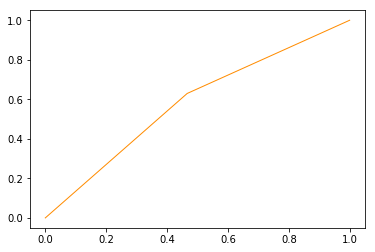

In [226]:
fpr, tpr, threshold = roc_curve(y_test,preds)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, color='darkorange',
         lw=1)

### Boosted SVM and SMOTE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.grid_search import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)

svc = SVC(probability=True,kernel='linear')

ada = AdaBoostClassifier(base_estimator = svc)

# crange = np.arange(1,11)
gammas = np.linspace((3/(X.shape[1])),(6/(X.shape[1])),20)
degrees = np.arange(1,11)

param_grid = {"smote__k_neighbors":[8,12,15],
              "smote__m_neighbors":[12,15,20],
              "ada__base_estimator__gamma":gammas,
              "ada__base_estimator__degree":degrees,     
              "ada__n_estimators": [10, 20, 30, 50, 100]
             }

pipeline = Pipeline([('smote',smote),
                    ('ada',ada)])

# run grid search
svm_ada_gs = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=10, scoring = 'recall')

svm_ada_gs.fit(X_train,y_train)




In [236]:
print(grid_search_svc.best_score_)
print(grid_search_svc.best_params_)
preds  = grid_search_svc.predict(X_test)
print(classification_report(y_test,preds))

0.0
{'n_estimators': 10}
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95       281
         1.0       0.00      0.00      0.00        27

   micro avg       0.91      0.91      0.91       308
   macro avg       0.46      0.50      0.48       308
weighted avg       0.83      0.91      0.87       308



C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Boosted SVM and SMOTE (simple - no grid search)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.grid_search import GridSearchCV

crange = np.arange(1,11)
gammas = np.linspace((3/(X.shape[1])),(6/(X.shape[1])),20)
degrees = np.arange(1,11)

param_grid = {"base_estimator__C":[1,10],
              "base_estimator__gamma":[3/(X.shape[1])],
              "base_estimator__degree":[3,6],     
              "n_estimators": [100]
             }

ada = AdaBoostClassifier(base_estimator = SVC(kernel="rbf"))

# run grid search
grid_search_dt = RandomizedSearchCV(ada, param_distributions=param_grid, scoring = 'recall')

grid_search_dt.fit(X,y)

## Multilayer Perceptron (Neural Network) 

MLPClassifier(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

## MLP

In [ ]:
print(mlp_smote_gridsearch.best_score_)
print(mlp_smote_gridsearch.best_params_)
preds  = mlp_smote_gridsearch.predict(X_test)
print(classification_report(y_test,preds))

In [258]:
# BELOW - JUST MLP

hiddenlayers = [(30,),(30,30,),(30,30,30,),(60,),(60,60,),(60,60,60,),(100,),(100,100,),(100,100,100,)]
activation = ['tanh','relu']
solver = ["sgd","adam"]
learning_rate_init = [.000001, .00001, .0001, .01, 1]
# learning_rate = ["constant","adaptive"]

mlp_grid = {"hidden_layer_sizes":hiddenlayers,
            "activation":activation,
            "solver":solver,
            "learning_rate":learning_rate,
            "learning_rate_init":learning_rate_init}


mlp_gridsearch = RandomizedSearchCV(MLPClassifier(), param_distributions=mlp_grid, cv=10, scoring = 'recall')

mlp_gridsearch.fit(X,y)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimi

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'hidden_layer_sizes': [(30,), (30, 30), (30, 30, 30), (60,), (60, 60), (60, 60, 60), (100,), (100, 100), (100, 100, 100)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'learning_rate': ['constant', 'adaptive'], 'learning_rate_init': [1e-06, 1e-05, 0.0001, 0.01, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_s

In [259]:
mlp_gridsearch.best_score_
mlp_gridsearch.best_params_

preds = mlp_gridsearch.predict(X)
print(classification_report(y,preds))

              precision    recall  f1-score   support

         0.0       0.90      0.62      0.74       935
         1.0       0.07      0.29      0.11        91

   micro avg       0.59      0.59      0.59      1026
   macro avg       0.48      0.45      0.42      1026
weighted avg       0.83      0.59      0.68      1026



## MULTILAYER PERCEPTRON WITH SMOTE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

smote = SMOTE(random_state=42)

mlp = MLPClassifier()

pipeline = Pipeline([('smote',smote),
                    ('mlp',mlp)])


param_grid = {"smote__k_neighbors":[5,10,15,20],
              "smote__m_neighbors":[10,15,20,25],
              "mlp__hidden_layer_sizes":[(30,),(30,30,),(30,30,30,),(60,),(60,60,),(60,60,60,),(100,),(100,100,),(100,100,100,)],
              "mlp__activation":['tanh','relu'],
              "mlp__solver":["sgd","adam"],
              "mlp__learning_rate_init":[.000001, .00001, .0001, .01, 1]}

mlp_smote_gridsearch = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=10, scoring='recall')

mlp_smote_gridsearch.fit(X_train,y_train)


# SURVIVAL REGRESSION (COX REGRESSION)

### Does Physical Activity reduce the risk of dementia?

In [44]:
# Outcome variable
idx = pd.IndexSlice
Dementia = MH.loc[:,idx["MAS_ID","DEM_W1","DEM_W2","DEM_W3","DEM_W4"]]

# Variable coding time to event
Time = Dems.loc[:,idx["TIS_W1":"TIS_W4"]]

# Exercise = PA
Exercise = PA[['PA_W1', 'PA_W2', 'PA_W3', 'PA_W4']]



In [45]:
# Process the predictor data

Medicalhistory = process_healthdata(Healthw1)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
C:\Users\z3160256\AppData\Loca

In [46]:
# Let's view that processed medical history data

display(Medicalhistory.head())

OTHERRAD_W1  CANCER_W1  CHEMO_W1  ALCOHOL_W1  ALCOHOL_BINARY_W1  \
Id                                                                    
1             0          0         0         0.0                0.0   
2             0          1         0         0.0                0.0   
3             0          0         0         0.0                0.0   
4             0          1         0         0.0                0.0   
5             0          0         0         0.0                0.0   

    SMOKES_W1  DIABETES_W1  DIABETES_YRS_W1  OTHERBRAIN_W1  CNS_W1  \
Id                                                                   
1         1.0            0              0.0              0       0   
2         1.0            0              0.0              0       1   
3         0.0            0              0.0              0       0   
4         0.0            0              0.0              0       0   
5         2.0            0              0.0              0       0   

    HEART_VASCULAR_W1  HEART_OTHER_W1  COPDALL_W1  ANAEMIA_W1  THYROIDPROB_W1  
Id                                                                             
1                   0               0           0         0.0             0.0  
2                   0               0           0         1.0             0.0  
3                   1               0           0         0.0             1.0  
4                   0               0           0         0.0             0.0  
5                   0               1           1         0.0             0.0

In [47]:
# Extract only a subset of the medical history columns to form the medical history covariates

Medical_covariates = Medicalhistory[['HEART_VASCULAR_W1',
                                    'HEART_OTHER_W1',
                                    'SMOKES_W1',
                                    'CANCER_W1',
                                   'ALCOHOL_BINARY_W1',
                                    'CNS_W1','OTHERBRAIN_W1',
                                     'DIABETES_YRS_W1'
                                    ]]

#ALCOHOL_W1

In [51]:
demographics = process_demsdata(Demsw1)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [52]:
# lets examine the processed demographics data

display(demographics.head())

FEMALE_W1  EDUCATION_W1     AGE_W1  NUMERACYLITERACY_W1  NESB_W1  \
Id                                                                     
1         1.0          12.0  74.264203                  0.0      0.0   
2         0.0          11.0  77.144422                  0.0      0.0   
3         1.0           9.0  81.557837                  0.0      0.0   
4         0.0           8.0  72.709103                  0.0      0.0   
5         0.0          12.0  78.146475                  0.0      1.0   

    RELATIVE_DEMENTIA_W1  RELATIVE_NEUROL_W1  RELATIVE_PSYCH_W1  APOE_W1_E2/2  \
Id                                                                              
1                      1                   1                  1             0   
2                      1                   1                  1             0   
3                      0                   0                  1             1   
4                      0                   0                  0             1   
5                      0                   0                  0             0   

    APOE_W1_E2/3     ...      OCCUPATION_W1_7.0  OCCUPATION_W1_8.0  \
Id                   ...                                             
1              0     ...                      0                  0   
2              0     ...                      0                  0   
3              0     ...                      0                  0   
4              0     ...                      0                  0   
5              0     ...                      0                  0   

    OCCUPATION_W1_9.0  OCCUPATION_W1_10.0  MARITAL_W1_1.0  MARITAL_W1_2.0  \
Id                                                                          
1                   0                   0             NaN               0   
2                   0                   0             NaN               1   
3                   0                   0             NaN               1   
4                   0                   0             NaN               1   
5                   0                   0             NaN               0   

    MARITAL_W1_3.0  MARITAL_W1_4.0  MARITAL_W1_5.0  NART_IQ_W1  
Id                                                              
1                0               1               0       113.0  
2                0               0               0       108.0  
3                0               0               0        92.0  
4                0               0               0        95.0  
5                0               1               0         0.0  

[5 rows x 33 columns]

In [53]:
demographics.columns

Index(['FEMALE_W1', 'EDUCATION_W1', 'AGE_W1', 'NUMERACYLITERACY_W1', 'NESB_W1',
       'RELATIVE_DEMENTIA_W1', 'RELATIVE_NEUROL_W1', 'RELATIVE_PSYCH_W1',
       'APOE_W1_E2/2', 'APOE_W1_E2/3', 'APOE_W1_E2/4', 'APOE_W1_E3/3',
       'APOE_W1_E3/4', 'APOE_W1_E4/4', 'APOE4CARRIER_W1', 'BMI_W1', 'WAIST_W1',
       'OCCUPATION_W1_1.0', 'OCCUPATION_W1_2.0', 'OCCUPATION_W1_3.0',
       'OCCUPATION_W1_4.0', 'OCCUPATION_W1_5.0', 'OCCUPATION_W1_6.0',
       'OCCUPATION_W1_7.0', 'OCCUPATION_W1_8.0', 'OCCUPATION_W1_9.0',
       'OCCUPATION_W1_10.0', 'MARITAL_W1_1.0', 'MARITAL_W1_2.0',
       'MARITAL_W1_3.0', 'MARITAL_W1_4.0', 'MARITAL_W1_5.0', 'NART_IQ_W1'],
      dtype='object')

In [55]:
#extract only some of the covariates

Demographic_covs = demographics[['AGE_W1',
                                'EDUCATION_W1',
                                'NESB_W1',
                                'APOE4CARRIER_W1'
                                ]]

In [56]:
# extract the column coding MALE from the original Dems data frame

Male = Dems["MALE_W1"]

In [58]:
# extract BMI

BMI = demographics["BMI_W1"]

In [59]:
# Extract SBP and depression

Systolic = SBP[["SBP_W1"]]
Dep = MH['DEPRESSION_W1']

In [60]:
# Extract self-rated health

GeneralHealth = MH[['GENHEALTH_W1']]

In [61]:
# Concatenate datasets in prep for survival analysis

cox_df = pd.concat([Dementia,BMI,Time,Exercise,Medical_covariates,Demographic_covs,Male,
          Systolic,Dep,GeneralHealth], axis=1)

cox_df.to_csv("Datasets/cox.csv")

In [75]:
# What are the final list of columns

cox_df.columns

Index(['MAS_ID', 'DEM_W1', 'DEM_W2', 'DEM_W3', 'DEM_W4', 'BMI_W1', 'TIS_W1',
       'TIS_W2', 'TIS_W3', 'TIS_W4', 'PA_W1', 'PA_W2', 'PA_W3', 'PA_W4',
       'HEART_VASCULAR_W1', 'HEART_OTHER_W1', 'SMOKES_W1', 'CANCER_W1',
       'ALCOHOL_BINARY_W1', 'CNS_W1', 'OTHERBRAIN_W1', 'DIABETES_YRS_W1',
       'AGE_W1', 'EDUCATION_W1', 'NESB_W1', 'APOE4CARRIER_W1', 'MALE_W1',
       'SBP_W1', 'DEPRESSION_W1', 'GENHEALTH_W1'],
      dtype='object')

In [76]:
# View preview of the dataset

cox_df.head()

MAS_ID  DEM_W1  DEM_W2  DEM_W3  DEM_W4     BMI_W1  TIS_W1    TIS_W2  \
Id                                                                       
1   0010A     0.0     NaN     NaN     NaN  21.968291     0.0       NaN   
2   0022A     0.0     0.0     0.0     0.0  26.056031     0.0  1.897331   
3   0033A     0.0     NaN     NaN     NaN  27.411890     0.0       NaN   
4   0042A     0.0     0.0     0.0     0.0  27.379994     0.0  1.968515   
5   0046A     0.0     0.0     0.0     0.0  25.099502     0.0  2.091718   

      TIS_W3    TIS_W4      ...       OTHERBRAIN_W1  DIABETES_YRS_W1  \
Id                          ...                                        
1        NaN       NaN      ...                   0              0.0   
2   4.052019  5.815195      ...                   0              0.0   
3        NaN       NaN      ...                   0              0.0   
4   4.344969  6.702259      ...                   0              0.0   
5   4.043806  6.140999      ...                   0              0.0   

       AGE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  \
Id                                                                           
1   74.264203          12.0      0.0                0      0.0  142.666667   
2   77.144422          11.0      0.0                0      1.0  183.000000   
3   81.557837           9.0      0.0                0      0.0  136.000000   
4   72.709103           8.0      0.0                0      1.0  141.666667   
5   78.146475          12.0      1.0                1      1.0  120.000000   

    DEPRESSION_W1  GENHEALTH_W1  
Id                               
1             NaN           4.0  
2             NaN           1.0  
3             1.0           4.0  
4             1.0           2.0  
5             1.0           3.0  

[5 rows x 30 columns]

### Calculate Target column and Duration (for dementia)

In [78]:
cox_df.head()

# Get the MAX of the dementia columns --> if the max is 1, they had dementia
cox_df["DEMENTIA"]=cox_df.loc[:,idx["DEM_W1":"DEM_W4"]].apply(np.max, axis=1)

# Get the max value for time - this will be their time to event value
cox_df["DURATION"]=cox_df.loc[:,idx["TIS_W1":"TIS_W4"]].apply(np.max, axis=1)

### Replace Target Column with Boolean
* We replace the "DEMENTIA" column that was initiall 0,1 with True/False

In [82]:
cox_df["DEMENTIA"] = cox_df["DEMENTIA"].replace({1:True,0:False})

In [83]:
cox_df = cox_df.loc[:,["MAS_ID",'PA_W1','HEART_VASCULAR_W1', 'HEART_OTHER_W1', 'SMOKES_W1', 'CANCER_W1',
       'ALCOHOL_BINARY_W1', 'CNS_W1', 'DIABETES_YRS_W1', 'OTHERBRAIN_W1','AGE_W1', 'MALE_W1',
       'EDUCATION_W1', 'NESB_W1', 'APOE4CARRIER_W1', 'BMI_W1', 'SBP_W1',
       'DEPRESSION_W1', 'GENHEALTH_W1', 'DEMENTIA', 'DURATION']]

In [84]:
# Lets preview just the last 10 columns

cox_df.iloc[:,10:].head()

AGE_W1  MALE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1     BMI_W1  \
Id                                                                          
1   74.264203      0.0          12.0      0.0                0  21.968291   
2   77.144422      1.0          11.0      0.0                0  26.056031   
3   81.557837      0.0           9.0      0.0                0  27.411890   
4   72.709103      1.0           8.0      0.0                0  27.379994   
5   78.146475      1.0          12.0      1.0                1  25.099502   

        SBP_W1  DEPRESSION_W1  GENHEALTH_W1  DEMENTIA  DURATION  
Id                                                               
1   142.666667            NaN           4.0     False  0.000000  
2   183.000000            NaN           1.0     False  5.815195  
3   136.000000            1.0           4.0     False  0.000000  
4   141.666667            1.0           2.0     False  6.702259  
5   120.000000            1.0           3.0     False  6.140999

In [88]:
# from lifelines.datasets import load_rossi
# rossi=load_rossi()
# rossi

In [521]:
# Convert TO LONG format for Cox regression - this is NOT a necessary step

from lifelines.utils import to_long_format
base_df = to_long_format(cox_df, duration_col="DURATION")

In [442]:
# ## NORMALIZE THE PHYSICAL ACTIVITY 

# base_df["PA_W1"] = np.log(base_df["PA_W1"]+1)

In [89]:
base_df = cox_df.copy()

base_df.set_index("MAS_ID", inplace=True)

display(base_df.head()) # Dataset is now in WIDE/LONG FORMAT

PA_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  CANCER_W1  \
MAS_ID                                                                         
0010A   1845.640977                  0               0        1.0          0   
0022A   1159.889903                  0               0        1.0          1   
0033A      0.000000                  1               0        0.0          0   
0042A    480.000000                  0               0        0.0          1   
0046A    531.616205                  0               1        2.0          0   

        ALCOHOL_BINARY_W1  CNS_W1  DIABETES_YRS_W1  OTHERBRAIN_W1     AGE_W1  \
MAS_ID                                                                         
0010A                 0.0       0              0.0              0  74.264203   
0022A                 0.0       1              0.0              0  77.144422   
0033A                 0.0       0              0.0              0  81.557837   
0042A                 0.0       0              0.0              0  72.709103   
0046A                 0.0       0              0.0              0  78.146475   

        MALE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1     BMI_W1  \
MAS_ID                                                               
0010A       0.0          12.0      0.0                0  21.968291   
0022A       1.0          11.0      0.0                0  26.056031   
0033A       0.0           9.0      0.0                0  27.411890   
0042A       1.0           8.0      0.0                0  27.379994   
0046A       1.0          12.0      1.0                1  25.099502   

            SBP_W1  DEPRESSION_W1  GENHEALTH_W1  DEMENTIA  DURATION  
MAS_ID                                                               
0010A   142.666667            NaN           4.0     False  0.000000  
0022A   183.000000            NaN           1.0     False  5.815195  
0033A   136.000000            1.0           4.0     False  0.000000  
0042A   141.666667            1.0           2.0     False  6.702259  
0046A   120.000000            1.0           3.0     False  6.140999

In [90]:
missingcols_filter = list(base_df.isnull().any())
cols_missing = base_df.columns[missingcols_filter]

In [91]:
#from scipy.stats import mode

# for loop replace missing values on all columns in the list "col_missing", with the mean of people of the same
# Sex and APOE4 combination

for col in cols_missing:
    
    base_df[col] = base_df[col].fillna(base_df.groupby(["APOE4CARRIER_W1","MALE_W1"])[col].transform(np.mean))

In [92]:
# are any columns missing values now??

base_df.isnull().any()

PA_W1                False
HEART_VASCULAR_W1    False
HEART_OTHER_W1       False
SMOKES_W1            False
CANCER_W1            False
ALCOHOL_BINARY_W1    False
CNS_W1               False
DIABETES_YRS_W1      False
OTHERBRAIN_W1        False
AGE_W1               False
MALE_W1              False
EDUCATION_W1         False
NESB_W1              False
APOE4CARRIER_W1      False
BMI_W1               False
SBP_W1               False
DEPRESSION_W1        False
GENHEALTH_W1         False
DEMENTIA             False
DURATION             False
dtype: bool

In [407]:
# base_df["DEPRESSION_W1"] = base_df["DEPRESSION_W1"].fillna(base_df.groupby("APOE4CARRIER_W1")["DEPRESSION_W1"].transform(np.mean))

In [526]:
# This step is NOT NEEDED unless we are using the long format (which we are not)

base_df.drop("start", axis=1, inplace=True)

In [93]:
# Center Age - calculate a Zscore for age

from scipy.stats import zscore

base_df["AGE_W1"] = zscore(base_df["AGE_W1"])

# base_df["AGE_W1"] = base_df["AGE_W1"] + 5

In [94]:
# Add interactions (Physical Activity and Sex)

base_df["SEX_PA"] = base_df["MALE_W1"] * base_df["PA_W1"]

In [95]:
# Add interaction (physical activity and baseline age)

base_df["AGE_PA"] = base_df["AGE_W1"] * base_df["PA_W1"]

In [462]:
# base_df2 = base_df.drop("CANCER_W1", axis=1)

In [96]:
# Run Cox regression 

from lifelines import CoxPHFitter
cph = CoxPHFitter()

cph.fit(base_df, duration_col="DURATION", event_col="DEMENTIA", show_progress=True)

Iteration 1: norm_delta = 0.96321, step_size = 0.9500, ll = -507.15118, newton_decrement = 35.85647, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.48279, step_size = 0.9500, ll = -471.88727, newton_decrement = 1.56258, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.13692, step_size = 0.9500, ll = -470.22024, newton_decrement = 0.06615, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.01499, step_size = 1.0000, ll = -470.15226, newton_decrement = 0.00070, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00009, step_size = 1.0000, ll = -470.15155, newton_decrement = 0.00000, seconds_since_start = 0.1
Convergence completed after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1026 observations, 935 censored>

In [97]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1026 observations, 935 censored>
      duration col = 'DURATION'
         event col = 'DEMENTIA'
number of subjects = 1026
  number of events = 91
    log-likelihood = -470.15
  time fit was run = 2019-05-03 14:23:51 UTC

---
                   coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
PA_W1             -0.00      1.00      0.00 -1.98   0.05      4.37       -0.00       -0.00
HEART_VASCULAR_W1  0.15      1.16      0.28  0.52   0.60      0.73       -0.41        0.70
HEART_OTHER_W1    -0.28      0.75      0.32 -0.89   0.38      1.41       -0.91        0.34
SMOKES_W1         -0.08      0.92      0.20 -0.39   0.69      0.53       -0.47        0.32
CANCER_W1         -0.56      0.57      0.24 -2.31   0.02      5.59       -1.04       -0.09
ALCOHOL_BINARY_W1 -1.02      0.36      1.02 -0.99   0.32      1.64       -3.02        0.99
CNS_W1             0.15      1.16      0.24  0.64   0.52      0.93       -0.31        0.62
DIABETES_Y

In [98]:
base_df.columns

Index(['PA_W1', 'HEART_VASCULAR_W1', 'HEART_OTHER_W1', 'SMOKES_W1',
       'CANCER_W1', 'ALCOHOL_BINARY_W1', 'CNS_W1', 'DIABETES_YRS_W1',
       'OTHERBRAIN_W1', 'AGE_W1', 'MALE_W1', 'EDUCATION_W1', 'NESB_W1',
       'APOE4CARRIER_W1', 'BMI_W1', 'SBP_W1', 'DEPRESSION_W1', 'GENHEALTH_W1',
       'DEMENTIA', 'DURATION', 'SEX_PA', 'AGE_PA'],
      dtype='object')

### PLOT THE COEFFICIENTS

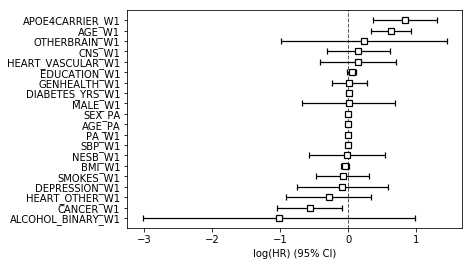

In [100]:
cph.plot()

# RELATIONSHIP BETWEEN PHYSICAL ACTIVITY AND SURVIVAL - PLOT

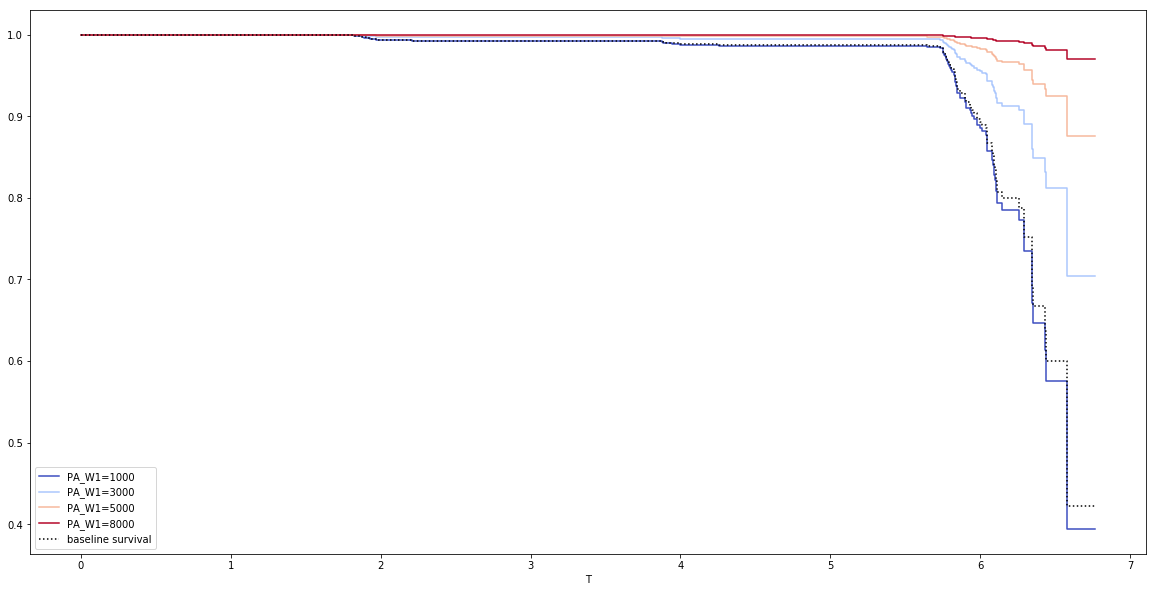

In [101]:
cph.plot_covariate_groups("PA_W1", [1000,3000,5000,8000], cmap = "coolwarm", figsize=(20,10))

# TIME VARYING COX REGRESSION

In [357]:
import os
print(os.getcwd())

cox_df = pd.read_csv("Datasets/cox.csv", index_col=0).sort_index()
display(cox_df.head())
display(cox_df.columns)

C:\Users\z3160256\OneDrive - UNSW\R Data Camp


MAS_ID  DEM_W1  DEM_W2  DEM_W3  DEM_W4     BMI_W1  TIS_W1    TIS_W2  \
Id                                                                       
1   0010A     0.0     NaN     NaN     NaN  21.968291     0.0       NaN   
2   0022A     0.0     0.0     0.0     0.0  26.056031     0.0  1.897331   
3   0033A     0.0     NaN     NaN     NaN  27.411890     0.0       NaN   
4   0042A     0.0     0.0     0.0     0.0  27.379994     0.0  1.968515   
5   0046A     0.0     0.0     0.0     0.0  25.099502     0.0  2.091718   

      TIS_W3    TIS_W4      ...       OTHERBRAIN_W1  DIABETES_YRS_W1  \
Id                          ...                                        
1        NaN       NaN      ...                   0              0.0   
2   4.052019  5.815195      ...                   0              0.0   
3        NaN       NaN      ...                   0              0.0   
4   4.344969  6.702259      ...                   0              0.0   
5   4.043806  6.140999      ...                   0              0.0   

       AGE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  \
Id                                                                           
1   74.264203          12.0      0.0                0      0.0  142.666667   
2   77.144422          11.0      0.0                0      1.0  183.000000   
3   81.557837           9.0      0.0                0      0.0  136.000000   
4   72.709103           8.0      0.0                0      1.0  141.666667   
5   78.146475          12.0      1.0                1      1.0  120.000000   

    DEPRESSION_W1  GENHEALTH_W1  
Id                               
1             NaN           4.0  
2             NaN           1.0  
3             1.0           4.0  
4             1.0           2.0  
5             1.0           3.0  

[5 rows x 30 columns]

Index(['MAS_ID', 'DEM_W1', 'DEM_W2', 'DEM_W3', 'DEM_W4', 'BMI_W1', 'TIS_W1',
       'TIS_W2', 'TIS_W3', 'TIS_W4', 'PA_W1', 'PA_W2', 'PA_W3', 'PA_W4',
       'HEART_VASCULAR_W1', 'HEART_OTHER_W1', 'SMOKES_W1', 'CANCER_W1',
       'ALCOHOL_BINARY_W1', 'CNS_W1', 'OTHERBRAIN_W1', 'DIABETES_YRS_W1',
       'AGE_W1', 'EDUCATION_W1', 'NESB_W1', 'APOE4CARRIER_W1', 'MALE_W1',
       'SBP_W1', 'DEPRESSION_W1', 'GENHEALTH_W1'],
      dtype='object')

### Time varying columns are:
* Time
* Dementia
* Physical Activity

In [295]:
# time_varying_cols_filter = cox_df.columns.str.contains("(PA)|(DEM)|(TIS)")
# time_invariant_cols_filter = ~cox_df.columns.str.contains("(PA)|(TIS)")

* I first need to create a "long" dataset for the physical activity variable
* for lifelines package - this "long" datset needs to contain the time-varying data (PA), as well as the time at each wave (i.e., TIS), and the person's id to identify multiple rows per person (MAS_ID)
* Note I also create a time-varying dataframe for DEMENTIA, but this is NOT needed - as the lifelines procedure will do this automatically when I merge the PA data to the time-invariant dataframe (from above - i.e., **base_df**)

In [359]:
# Now create 3 separate data frames, one for each of DEM, PA, and TIS
# Keep the MAS_ID column as a way to merge these to the time_invariant columns later

dementia_df = cox_df.loc[:,cox_df.columns.str.contains("(DEM)|(MAS_ID)", regex=True)]
tis_df = cox_df.loc[:,cox_df.columns.str.contains("(TIS)|(MAS_ID)", regex=True)]
pa_df = cox_df.loc[:,cox_df.columns.str.contains("(PA)|(MAS_ID)", regex=True)]


C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


### MELT each of these time-varying dfs - do this as a LOOP by compiling those dfs into a list

In [796]:
# create a list of the dataframes to melt, AND a list of the names to label their columns, then zip them
# Iterate over the tuple

time_varying_dfs = [dementia_df,tis_df,pa_df]
time_varying_names = ["dementia","tis","pa"]
time_varying_tuple = list(zip(time_varying_dfs,time_varying_names))
display(time_varying_tuple) # shows each data frame and its name "dementia/tis/pa" in the tuple

# Now run loop combined with melt - each data frame in the list is melted to make it long
# the strings in the "time_varying_names" list, are used to label the columns in each melted dataframe

long_dfs=[]

for key, value in time_varying_tuple:
    
    long_dataset = pd.melt(frame=key, 
                           id_vars="MAS_ID", 
                           var_name="{}_label".format(value), 
                           value_name="{}".format(value))
    
    long_dfs.append(long_dataset)

    
# from the combined list of MELTED dataframes - extract each indivdiual LONG dataset 

dem_long = long_dfs[0] # this dataset is NOT needed for the subsequent steps
tis_long = long_dfs[1]
pa_long = long_dfs[2]


[(     MAS_ID  DEM_W1  DEM_W2  DEM_W3  DEM_W4
  Id                                         
  1     0010A     0.0     NaN     NaN     NaN
  2     0022A     0.0     0.0     0.0     0.0
  3     0033A     0.0     NaN     NaN     NaN
  4     0042A     0.0     0.0     0.0     0.0
  5     0046A     0.0     0.0     0.0     0.0
  6     0082A     0.0     0.0     0.0     0.0
  7     0084A     0.0     NaN     NaN     NaN
  8     0088A     0.0     0.0     0.0     0.0
  9     0091A     0.0     0.0     0.0     0.0
  10    0097A     0.0     NaN     NaN     NaN
  11    0099A     0.0     0.0     0.0     0.0
  12    0123A     0.0     NaN     NaN     NaN
  13    0133A     0.0     0.0     0.0     0.0
  14    0135A     0.0     0.0     0.0     0.0
  15    0137A     0.0     0.0     0.0     0.0
  16    0138A     0.0     0.0     0.0     0.0
  17    0141A     0.0     0.0     0.0     0.0
  18    0142A     0.0     1.0     NaN     NaN
  19    0148A     0.0     NaN     NaN     NaN
  20    0150A     0.0     0.0     

In [797]:
# sort each data frame so that the rows are ordered by wave - this step is NOT needed
dem_long = dem_long.sort_values(by=["MAS_ID","dementia_label"])
tis_long = tis_long.sort_values(by=["MAS_ID","tis_label"])
pa_long = pa_long.sort_values(by=["MAS_ID","pa_label"])
display(dem_long.head())

# Change the values in the "label" columns, so that they only are W1, W2, W3, W4
# As opposed to "DEM_W1","DEM_W2" and so on...

dem_long["dementia_label"] = dem_long["dementia_label"].replace({"(DEM_)":""}, regex=True)
tis_long["tis_label"] = tis_long["tis_label"].replace({"(TIS_)":""}, regex=True)
pa_long["pa_label"] = pa_long["pa_label"].replace({"(PA_)":""}, regex=True)
display(dem_long.head())


MAS_ID dementia_label  dementia
0     0010A         DEM_W1       0.0
1026  0010A         DEM_W2       NaN
2052  0010A         DEM_W3       NaN
3078  0010A         DEM_W4       NaN
1     0022A         DEM_W1       0.0

MAS_ID dementia_label  dementia
0     0010A             W1       0.0
1026  0010A             W2       NaN
2052  0010A             W3       NaN
3078  0010A             W4       NaN
1     0022A             W1       0.0

In [798]:
# create the dataset with the time-invariant cols only

time_invariant_cols_filter = ~cox_df.columns.str.contains("(PA)|(TIS)|(DEM)") 
# all cols in cox_df that are NOT PA or TIS (~)

covariates_df = cox_df.loc[:,time_invariant_cols_filter]

display(covariates_df.head()) # note only covariates remain (the non time varying ones)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


MAS_ID     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  CANCER_W1  \
Id                                                                              
1   0010A  21.968291                  0               0        1.0          0   
2   0022A  26.056031                  0               0        1.0          1   
3   0033A  27.411890                  1               0        0.0          0   
4   0042A  27.379994                  0               0        0.0          1   
5   0046A  25.099502                  0               1        2.0          0   

    ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1  DIABETES_YRS_W1     AGE_W1  \
Id                                                                         
1                 0.0       0              0              0.0  74.264203   
2                 0.0       1              0              0.0  77.144422   
3                 0.0       0              0              0.0  81.557837   
4                 0.0       0              0              0.0  72.709103   
5                 0.0       0              0              0.0  78.146475   

    EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  \
Id                                                                
1           12.0      0.0                0      0.0  142.666667   
2           11.0      0.0                0      1.0  183.000000   
3            9.0      0.0                0      0.0  136.000000   
4            8.0      0.0                0      1.0  141.666667   
5           12.0      1.0                1      1.0  120.000000   

    DEPRESSION_W1  GENHEALTH_W1  
Id                               
1             NaN           4.0  
2             NaN           1.0  
3             1.0           4.0  
4             1.0           2.0  
5             1.0           3.0

## PROPER TIME-VARYING COX REGRESSION
* We need to convert the one-row-per-person dataset we used above in the Cox regression into "long"
* Note, it is still one row per person at this stage

In [799]:
base_df.head()

PA_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  CANCER_W1  \
MAS_ID                                                                         
0010A   1845.640977                  0               0        1.0          0   
0022A   1159.889903                  0               0        1.0          1   
0033A      0.000000                  1               0        0.0          0   
0042A    480.000000                  0               0        0.0          1   
0046A    531.616205                  0               1        2.0          0   

        ALCOHOL_BINARY_W1  CNS_W1  DIABETES_YRS_W1  OTHERBRAIN_W1    AGE_W1  \
MAS_ID                                                                        
0010A                 0.0       0              0.0              0 -0.948274   
0022A                 0.0       1              0.0              0 -0.349277   
0033A                 0.0       0              0.0              0  0.568578   
0042A                 0.0       0              0.0              0 -1.271686   
0046A                 0.0       0              0.0              0 -0.140880   

           ...       NESB_W1  APOE4CARRIER_W1     BMI_W1      SBP_W1  \
MAS_ID     ...                                                         
0010A      ...           0.0                0  21.968291  142.666667   
0022A      ...           0.0                0  26.056031  183.000000   
0033A      ...           0.0                0  27.411890  136.000000   
0042A      ...           0.0                0  27.379994  141.666667   
0046A      ...           1.0                1  25.099502  120.000000   

        DEPRESSION_W1  GENHEALTH_W1  DEMENTIA  DURATION       SEX_PA  \
MAS_ID                                                                 
0010A        0.188940           4.0     False  0.000000     0.000000   
0022A        0.130058           1.0     False  5.815195  1159.889903   
0033A        1.000000           4.0     False  0.000000     0.000000   
0042A        1.000000           2.0     False  6.702259   480.000000   
0046A        1.000000           3.0     False  6.140999   531.616205   

             AGE_PA  
MAS_ID               
0010A  -1750.172709  
0022A   -405.122520  
0033A      0.000000  
0042A   -610.409498  
0046A    -74.894317  

[5 rows x 22 columns]

In [369]:
# begin by using the base-df data from the time invariant Cox reg I did above

from lifelines.utils import to_long_format

base_df_long = base_df.copy()

base_df_long = to_long_format(base_df_long, duration_col="DURATION")

base_df_long.head(10)

base_df_long = base_df_long.reset_index()  # I reset index so I can use it to merge with the pa data

# this dataset is one person per row

display(base_df_long.head(5)) # Note the "start" and "Stop columns"

MAS_ID        PA_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0  0010A  1845.640977                  0               0        1.0   
1  0022A  1159.889903                  0               0        1.0   
2  0033A     0.000000                  1               0        0.0   
3  0042A   480.000000                  0               0        0.0   
4  0046A   531.616205                  0               1        2.0   

   CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  DIABETES_YRS_W1  OTHERBRAIN_W1  \
0          0                0.0       0              0.0              0   
1          1                0.0       1              0.0              0   
2          0                0.0       0              0.0              0   
3          1                0.0       0              0.0              0   
4          0                0.0       0              0.0              0   

     ...     APOE4CARRIER_W1     BMI_W1      SBP_W1  DEPRESSION_W1  \
0    ...                   0  21.968291  142.666667       0.188940   
1    ...                   0  26.056031  183.000000       0.130058   
2    ...                   0  27.411890  136.000000       1.000000   
3    ...                   0  27.379994  141.666667       1.000000   
4    ...                   1  25.099502  120.000000       1.000000   

   GENHEALTH_W1  DEMENTIA       SEX_PA       AGE_PA  start      stop  
0           4.0     False     0.000000 -1750.172709      0  0.000000  
1           1.0     False  1159.889903  -405.122520      0  5.815195  
2           4.0     False     0.000000     0.000000      0  0.000000  
3           2.0     False   480.000000  -610.409498      0  6.702259  
4           3.0     False   531.616205   -74.894317      0  6.140999  

[5 rows x 24 columns]

### Create the proper LONG dataset for physical activity (contains ID, PA, and Time)

In [370]:
# NOw I need to prepare the physical activity dataset so it is long
# The long pa dataset is "pa_long", but it has NO time information yet - so must merge with the tis dataset

final_pa = pd.concat([pa_long,tis_long], axis=1)
# I can use concat because they share the same index

final_pa = final_pa.loc[:,~final_pa.columns.duplicated()] # remove the duplicated cols

final_pa.drop(["pa_label","tis_label"], axis=1, inplace=True) # remove the "_label" columns

final_pa = final_pa.dropna(subset=["tis"]) # drop the nans on the tis column - these rows are useless!



### We need to calculate a MIDPOINT TIME column - this can be the only valid time when the time varying covariate occurred - the TIME at which a time-varying covariate occurs cannot overlap with event time
**TIME when the covariate occurs CANNOT overlap with the time the event occurs**

In [371]:
# shift the current time column forward
final_pa["shifted"] = final_pa["tis"].shift(1) 

# create a new col that is the midpoint between the current time and the lagged time 
final_pa["midpoint"] = (final_pa["tis"]+final_pa["shifted"])/2  

# replace nans (which occur when shifting) with 0s
final_pa["midpoint"] = final_pa["midpoint"].replace({np.nan:0})

display(final_pa.head(10))

# rename the midpoint column to "time"
final_pa = final_pa.rename(columns={"midpoint":"time"})
display(final_pa.head(10))

# subset the final PA long dataset - only to contain ID, time, and amount of PA
final_pa = final_pa.loc[:,["MAS_ID","pa","time"]].reset_index(drop=True)

display(final_pa.head(5))

MAS_ID           pa       tis   shifted  midpoint
0     0010A  1845.640977  0.000000       NaN  0.000000
1     0022A  1159.889903  0.000000  0.000000  0.000000
1027  0022A   257.753312  1.897331  0.000000  0.948665
2053  0022A     0.000000  4.052019  1.897331  2.974675
3079  0022A   529.972476  5.815195  4.052019  4.933607
2     0033A     0.000000  0.000000  5.815195  2.907598
3     0042A   480.000000  0.000000  0.000000  0.000000
1029  0042A   739.199676  1.968515  0.000000  0.984257
2055  0042A    12.887666  4.344969  1.968515  3.156742
3081  0042A    38.662997  6.702259  4.344969  5.523614

MAS_ID           pa       tis   shifted      time
0     0010A  1845.640977  0.000000       NaN  0.000000
1     0022A  1159.889903  0.000000  0.000000  0.000000
1027  0022A   257.753312  1.897331  0.000000  0.948665
2053  0022A     0.000000  4.052019  1.897331  2.974675
3079  0022A   529.972476  5.815195  4.052019  4.933607
2     0033A     0.000000  0.000000  5.815195  2.907598
3     0042A   480.000000  0.000000  0.000000  0.000000
1029  0042A   739.199676  1.968515  0.000000  0.984257
2055  0042A    12.887666  4.344969  1.968515  3.156742
3081  0042A    38.662997  6.702259  4.344969  5.523614

MAS_ID           pa      time
0  0010A  1845.640977  0.000000
1  0022A  1159.889903  0.000000
2  0022A   257.753312  0.948665
3  0022A     0.000000  2.974675
4  0022A   529.972476  4.933607

In [372]:
# NOW we can join the time varying covariate to the one-row-per-person (LONG) dataset

from lifelines.utils import add_covariate_to_timeline

final_df = add_covariate_to_timeline(base_df_long, final_pa, 
                                     duration_col="time", id_col="MAS_ID", event_col="DEMENTIA")

In [374]:
final_df.loc[final_df["DEMENTIA"]==True,:].head(15)

AGE_PA    AGE_W1  ALCOHOL_BINARY_W1  APOE4CARRIER_W1     BMI_W1  \
57   -724.480531 -1.362789                0.0              0.0  32.791945   
61      0.000000  0.856689                0.0              0.0  26.912310   
148  1949.250404  2.236318                0.0              0.0  25.390625   
152  1741.053332  1.513763                0.0              0.0  24.398479   
198   193.665491  1.152771                0.0              0.0  30.430031   
253  1760.702839  0.828219                0.0              1.0  22.629758   
326   197.955574  0.584521                0.0              0.0  27.636054   
388   -45.384653 -0.658455                0.0              0.0  29.580458   
496  -165.823491 -0.714824                0.0              1.0  32.914201   
524   -83.303633 -0.094191                0.0              1.0  27.958478   
565   309.082543  0.380680                0.0              0.0  27.801209   
616 -3882.603533 -1.243786                0.0              0.0  25.389446   
677     0.000000  1.290563                0.0              0.0  29.830888   
689  -502.750418 -0.352124                0.0              0.0  23.055685   
729   -92.253305 -0.908986                0.0              1.0  24.303678   

     CANCER_W1  CNS_W1  DEMENTIA  DEPRESSION_W1  DIABETES_YRS_W1    ...     \
57         0.0     0.0      True        0.00000         1.271047    ...      
61         1.0     0.0      True        0.18894         0.000000    ...      
148        0.0     0.0      True        0.18894         0.000000    ...      
152        1.0     0.0      True        0.00000         0.000000    ...      
198        1.0     1.0      True        0.18894         0.000000    ...      
253        1.0     0.0      True        0.00000         0.000000    ...      
326        0.0     0.0      True        0.00000        12.634497    ...      
388        0.0     1.0      True        0.00000         0.000000    ...      
496        0.0     0.0      True        0.00000         0.000000    ...      
524        1.0     0.0      True        0.00000         0.000000    ...      
565        1.0     0.0      True        0.00000        60.654346    ...      
616        0.0     1.0      True        0.00000         0.000000    ...      
677        1.0     1.0      True        0.00000        55.029432    ...      
689        0.0     1.0      True        0.00000         0.000000    ...      
729        1.0     0.0      True        1.00000         0.000000    ...      

     MAS_ID  NESB_W1  OTHERBRAIN_W1        PA_W1      SBP_W1       SEX_PA  \
57    0142A      1.0            0.0   531.616205  151.000000     0.000000   
61    0150A      0.0            0.0     0.000000  137.666667     0.000000   
148   0306A      1.0            0.0   871.633999  129.000000     0.000000   
152   0308A      0.0            0.0  1150.149037  134.000000     0.000000   
198   0379A      0.0            0.0   168.000000  114.333333     0.000000   
253   0506A      0.0            0.0  2125.889903  156.333333  2125.889903   
326   0653A      0.0            0.0   338.662997  125.000000     0.000000   
388   0744A      0.0            0.0    68.925997  149.500000     0.000000   
496   0994A      0.0            0.0   231.977981  139.000000     0.000000   
524   1054A      0.0            0.0   884.416051  172.333333   884.416051   
565   1183A      0.0            0.0   811.922932  162.333333   811.922932   
616   1243A      0.0            0.0  3121.599912  146.333333  3121.599912   
677   1448A      0.0            0.0     0.000000  131.666667     0.000000   
689   1477A      0.0            0.0  1427.766707  142.666667  1427.766707   
729   1517A      0.0            0.0   101.490366  128.666667   101.490366   

     SMOKES_W1           pa     start      stop  
57         0.0          NaN  0.000000  1.984942  
61         0.0     0.000000  5.069131  6.113621  
148        0.0   128.876656  5.067762  6.102669  
152        0.0  1050.000000  5.026694  6.047912  
198        1.0    77.325994  1.106092  2.2121

## NANS CANNOT BE USED!!

In [375]:
# any cols have nulls?

final_df.isnull().any()

AGE_PA               False
AGE_W1               False
ALCOHOL_BINARY_W1    False
APOE4CARRIER_W1      False
BMI_W1               False
CANCER_W1            False
CNS_W1               False
DEMENTIA             False
DEPRESSION_W1        False
DIABETES_YRS_W1      False
EDUCATION_W1         False
GENHEALTH_W1         False
HEART_OTHER_W1       False
HEART_VASCULAR_W1    False
MALE_W1              False
MAS_ID               False
NESB_W1              False
OTHERBRAIN_W1        False
PA_W1                False
SBP_W1               False
SEX_PA               False
SMOKES_W1            False
pa                    True
start                False
stop                 False
dtype: bool

In [376]:
# fill na with mean
    
final_df["pa"] = final_df["pa"].fillna(final_df.groupby(["APOE4CARRIER_W1","MALE_W1"])["pa"].transform(np.mean))

In [377]:
final_df.isnull().any()

AGE_PA               False
AGE_W1               False
ALCOHOL_BINARY_W1    False
APOE4CARRIER_W1      False
BMI_W1               False
CANCER_W1            False
CNS_W1               False
DEMENTIA             False
DEPRESSION_W1        False
DIABETES_YRS_W1      False
EDUCATION_W1         False
GENHEALTH_W1         False
HEART_OTHER_W1       False
HEART_VASCULAR_W1    False
MALE_W1              False
MAS_ID               False
NESB_W1              False
OTHERBRAIN_W1        False
PA_W1                False
SBP_W1               False
SEX_PA               False
SMOKES_W1            False
pa                   False
start                False
stop                 False
dtype: bool

In [378]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3651 entries, 0 to 3650
Data columns (total 25 columns):
AGE_PA               3651 non-null float64
AGE_W1               3651 non-null float64
ALCOHOL_BINARY_W1    3651 non-null float64
APOE4CARRIER_W1      3651 non-null float64
BMI_W1               3651 non-null float64
CANCER_W1            3651 non-null float64
CNS_W1               3651 non-null float64
DEMENTIA             3651 non-null bool
DEPRESSION_W1        3651 non-null float64
DIABETES_YRS_W1      3651 non-null float64
EDUCATION_W1         3651 non-null float64
GENHEALTH_W1         3651 non-null float64
HEART_OTHER_W1       3651 non-null float64
HEART_VASCULAR_W1    3651 non-null float64
MALE_W1              3651 non-null float64
MAS_ID               3651 non-null object
NESB_W1              3651 non-null float64
OTHERBRAIN_W1        3651 non-null float64
PA_W1                3651 non-null float64
SBP_W1               3651 non-null float64
SEX_PA               3651 non-null fl

In [379]:
# check again if there are NO MORE MISSING COLS

display(final_df.isnull().any()) # ALL FALSE - thus no missing cols


# Keep a subset of the columns only for simplicity
# Retain the ID, start, stop, and EVENT, and time-varying (pa) columns

final_cols = ['MAS_ID','AGE_W1','BMI_W1','EDUCATION_W1','APOE4CARRIER_W1','pa','start','stop','DEMENTIA']
final_df = final_df[final_cols]
display(final_df.head())



AGE_PA               False
AGE_W1               False
ALCOHOL_BINARY_W1    False
APOE4CARRIER_W1      False
BMI_W1               False
CANCER_W1            False
CNS_W1               False
DEMENTIA             False
DEPRESSION_W1        False
DIABETES_YRS_W1      False
EDUCATION_W1         False
GENHEALTH_W1         False
HEART_OTHER_W1       False
HEART_VASCULAR_W1    False
MALE_W1              False
MAS_ID               False
NESB_W1              False
OTHERBRAIN_W1        False
PA_W1                False
SBP_W1               False
SEX_PA               False
SMOKES_W1            False
pa                   False
start                False
stop                 False
dtype: bool

MAS_ID    AGE_W1     BMI_W1  EDUCATION_W1  APOE4CARRIER_W1           pa  \
0  0010A -0.948274  21.968291          12.0              0.0  1845.640977   
1  0022A -0.349277  26.056031          11.0              0.0  1159.889903   
2  0022A -0.349277  26.056031          11.0              0.0   257.753312   
3  0022A -0.349277  26.056031          11.0              0.0     0.000000   
4  0022A -0.349277  26.056031          11.0              0.0   529.972476   

      start      stop  DEMENTIA  
0  0.000000  0.000000     False  
1  0.000000  0.948665     False  
2  0.948665  2.974675     False  
3  2.974675  4.933607     False  
4  4.933607  5.815195     False


# # delete all rows where start and stop = 0; OR delete rows if the srart and stop time is identical - NOT COMPULSORY

In [324]:
final_df = final_df.loc[(final_df["start"]!=final_df["stop"]),:]
display(final_df.head())

## DATASET IS NOW PREPARED FOR COX REGRESSION

<lifelines.CoxTimeVaryingFitter: fitted with 3651 periods, 1026 subjects, 91 events>
         event col = 'DEMENTIA'
number of subjects = 1026
 number of periods = 3651
  number of events = 91
    log-likelihood = -480.23
  time fit was run = 2019-05-05 06:55:49 UTC

---
                 coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
AGE_W1           0.68      1.97      0.11  6.46 <0.005     33.17        0.47        0.89
BMI_W1          -0.03      0.97      0.03 -1.23   0.22      2.18       -0.09        0.02
EDUCATION_W1     0.06      1.06      0.03  2.02   0.04      4.54        0.00        0.12
APOE4CARRIER_W1  0.81      2.25      0.23  3.47 <0.005     10.90        0.35        1.27
pa              -0.00      1.00      0.00 -0.21   0.83      0.27       -0.00        0.00
---
Log-likelihood ratio test = 53.84 on 5 df, -log2(p)=32.04


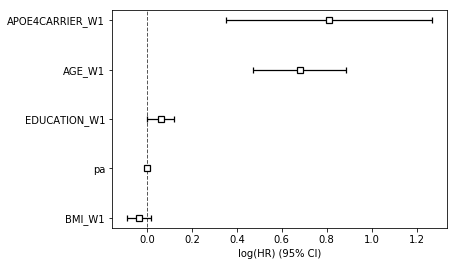

In [380]:
from lifelines import CoxTimeVaryingFitter


ctv = CoxTimeVaryingFitter()
ctv.fit(final_df, id_col="MAS_ID", event_col="DEMENTIA", start_col="start", stop_col="stop")

ctv.print_summary()

ctv.plot() # note that rows with 0,0 for start,stop have been deleted!

# BELOW IS EXTRA - MANUALLY CREATING A DATASET FOR COX REG
* This is not complete, since I do not lag the start and stop time manually

In [800]:
# Let's do a MANY TO ONE merge with the dementia data, having MAS_ID as the id variable

long_dataset = pd.merge(left=dem_long, right=covariates_df, on="MAS_ID")

display(long_dataset.head())

# Merge the other datasets

long_dataset = pd.merge(left=long_dataset, right=pa_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","pa_label"])

display(long_dataset.head())

# Merge the final tis dataset

long_dataset = pd.merge(left=long_dataset, right=tis_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","tis_label"])

display(long_dataset.head())

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

   OTHERBRAIN_W1  DIABETES_YRS_W1     AGE_W1  EDUCATION_W1  NESB_W1  \
0              0              0.0  74.264203          12.0      0.0   
1              0              0.0  74.264203          12.0      0.0   
2              0              0.0  74.264203          12.0      0.0   
3              0              0.0  74.264203          12.0      0.0   
4              0              0.0  77.144422          11.0      0.0   

   APOE4CARRIER_W1  MALE_W1      SBP_W1  DEPRESSION_W1  GENHEALTH_W1  
0                0      0.0  142.666667            NaN           4.0  
1                0      0.0  142.666667            NaN           4.0  
2                0      0.0  142.666667            NaN           4.0  
3                0      0.0  142.666667            NaN           4.0  
4                0      1.0  183.000000            NaN           1.0

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

      ...          AGE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1  \
0     ...       74.264203          12.0      0.0                0      0.0   
1     ...       74.264203          12.0      0.0                0      0.0   
2     ...       74.264203          12.0      0.0                0      0.0   
3     ...       74.264203          12.0      0.0                0      0.0   
4     ...       77.144422          11.0      0.0                0      1.0   

       SBP_W1  DEPRESSION_W1  GENHEALTH_W1  pa_label           pa  
0  142.666667            NaN           4.0        W1  1845.640977  
1  142.666667            NaN           4.0        W2          NaN  
2  142.666667            NaN           4.0        W3          NaN  
3  142.666667            NaN           4.0        W4          NaN  
4  183.000000            NaN           1.0        W1  1159.889903  

[5 rows x 22 columns]

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1 ...   \
0               0        1.0          0                0.0       0 ...    
1               0        1.0          0                0.0       0 ...    
2               0        1.0          0                0.0       0 ...    
3               0        1.0          0                0.0       0 ...    
4               0        1.0          1                0.0       1 ...    

   NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  DEPRESSION_W1  GENHEALTH_W1  \
0      0.0                0      0.0  142.666667            NaN           4.0   
1      0.0                0      0.0  142.666667            NaN           4.0   
2      0.0                0      0.0  142.666667            NaN           4.0   
3      0.0                0      0.0  142.666667            NaN           4.0   
4      0.0                0      1.0  183.000000            NaN           1.0   

   pa_label           pa  tis_label  tis  
0        W1  1845.640977         W1  0.0  
1        W2          NaN         W2  NaN  
2        W3          NaN         W3  NaN  
3        W4          NaN         W4  NaN  
4        W1  1159.889903         W1  0.0  

[5 rows x 24 columns]

* **dataset has now been prepared**, where each person has FOUR rows!
* we need to now delete all rows where the DEMENTIA = np.nan

In [801]:
long_dataset_clean = long_dataset.dropna(subset=["dementia"])

long_dataset_clean.drop(['pa_label','tis_label','dementia_label'], axis=1, inplace=True)

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [802]:
long_dataset_clean.head()

# We have restructured the dataset - the row where people drop out of the study or have dementia - they are OUT

long_dataset_clean.sort_values(by=["MAS_ID","tis"], inplace=True)
long_dataset_clean.head(10)

# The dataset is prepared for Cox regression

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0   0010A       0.0  21.968291                  0               0        1.0   
4   0022A       0.0  26.056031                  0               0        1.0   
5   0022A       0.0  26.056031                  0               0        1.0   
6   0022A       0.0  26.056031                  0               0        1.0   
7   0022A       0.0  26.056031                  0               0        1.0   
8   0033A       0.0  27.411890                  1               0        0.0   
12  0042A       0.0  27.379994                  0               0        0.0   
13  0042A       0.0  27.379994                  0               0        0.0   
14  0042A       0.0  27.379994                  0               0        0.0   
15  0042A       0.0  27.379994                  0               0        0.0   

    CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1    ...        AGE_W1  \
0           0                0.0       0              0    ...     74.264203   
4           1                0.0       1              0    ...     77.144422   
5           1                0.0       1              0    ...     77.144422   
6           1                0.0       1              0    ...     77.144422   
7           1                0.0       1              0    ...     77.144422   
8           0                0.0       0              0    ...     81.557837   
12          1                0.0       0              0    ...     72.709103   
13          1                0.0       0              0    ...     72.709103   
14          1                0.0       0              0    ...     72.709103   
15          1                0.0       0              0    ...     72.709103   

    EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  \
0           12.0      0.0                0      0.0  142.666667   
4           11.0      0.0                0      1.0  183.000000   
5           11.0      0.0                0      1.0  183.000000   
6           11.0      0.0                0      1.0  183.000000   
7           11.0      0.0                0      1.0  183.000000   
8            9.0      0.0                0      0.0  136.000000   
12           8.0      0.0                0      1.0  141.666667   
13           8.0      0.0                0      1.0  141.666667   
14           8.0      0.0                0      1.0  141.666667   
15           8.0      0.0                0      1.0  141.666667   

    DEPRESSION_W1  GENHEALTH_W1           pa       tis  
0             NaN           4.0  1845.640977  0.000000  
4             NaN           1.0  1159.889903  0.000000  
5             NaN           1.0   257.753312  1.897331  
6             NaN           1.0     0.000000  4.052019  
7             NaN           1.0   529.972476  5.815195  
8             1.0           4.0     0.000000  0.000000  
12            1.0           2.0   480.000000  0.000000  
13            1.0           2.0   739.199676  1.968515  
14            1.0           2.0    12.887666  4.344969  
15            1.0           2.0    38.662997  6.702259  

[10 rows x 21 columns]

# GENERALIZED ESTIMATING EQUATIONS AND MIXED MODELLING

* I will conduct GEE and MLM using the cognitive data as the outcome variables
* The Cog dataset contains the scores on cognitive measures on all four waves

In [803]:
Cog.head() 

MAS_ID  DSYM_W1  TMTA_W1  BNT_W1  ANIMAL_W1  TMTB_W1  FAS_W1  RVLTTOTAL_W1  \
Id                                                                              
1   0010A     41.0     82.0    22.0       11.0    219.0    40.0          30.0   
2   0022A     55.0     37.0    25.0       13.0    118.0    34.0          36.0   
3   0033A     58.0     42.0    21.0       12.0    105.0    26.0          27.0   
4   0042A     57.0     29.0    28.0       12.0     63.0    37.0          42.0   
5   0046A     50.0     42.0    24.0       14.0      NaN    42.0          28.0   

    RVLT6_W1  RVLT7_W1     ...      ANIMAL_W4  RVLTTOTAL_W4  RVLT6_W4  \
Id                         ...                                          
1        3.0       3.0     ...            NaN           NaN       NaN   
2        8.0       6.0     ...           13.0          27.0       5.0   
3        0.0       0.0     ...            NaN           NaN       NaN   
4       12.0      10.0     ...            NaN           NaN       NaN   
5        3.0       6.0     ...           10.0          17.0       2.0   

    RVLT7_W4  LM_DELAY_W4  BVRT_W4  BNT_W4  FAS_W4  BLOCK_W4  NART_IQ_W1  
Id                                                                        
1        NaN          NaN      NaN     NaN     NaN       NaN       113.0  
2        5.0          6.0     12.0    25.0    24.0      18.0       108.0  
3        NaN          NaN      NaN     NaN     NaN       NaN        92.0  
4        NaN          NaN      NaN     NaN     NaN       NaN        95.0  
5        2.0         10.0     10.0    24.0    24.0      23.0         NaN  

[5 rows x 50 columns]

In [804]:
# need to replace 777's
Cog.describe()

Cog = Cog.applymap(lambda x: np.nan if x == 777 else x)
Cog.head()

MAS_ID  DSYM_W1  TMTA_W1  BNT_W1  ANIMAL_W1  TMTB_W1  FAS_W1  RVLTTOTAL_W1  \
Id                                                                              
1   0010A     41.0     82.0    22.0       11.0    219.0    40.0          30.0   
2   0022A     55.0     37.0    25.0       13.0    118.0    34.0          36.0   
3   0033A     58.0     42.0    21.0       12.0    105.0    26.0          27.0   
4   0042A     57.0     29.0    28.0       12.0     63.0    37.0          42.0   
5   0046A     50.0     42.0    24.0       14.0      NaN    42.0          28.0   

    RVLT6_W1  RVLT7_W1     ...      ANIMAL_W4  RVLTTOTAL_W4  RVLT6_W4  \
Id                         ...                                          
1        3.0       3.0     ...            NaN           NaN       NaN   
2        8.0       6.0     ...           13.0          27.0       5.0   
3        0.0       0.0     ...            NaN           NaN       NaN   
4       12.0      10.0     ...            NaN           NaN       NaN   
5        3.0       6.0     ...           10.0          17.0       2.0   

    RVLT7_W4  LM_DELAY_W4  BVRT_W4  BNT_W4  FAS_W4  BLOCK_W4  NART_IQ_W1  
Id                                                                        
1        NaN          NaN      NaN     NaN     NaN       NaN       113.0  
2        5.0          6.0     12.0    25.0    24.0      18.0       108.0  
3        NaN          NaN      NaN     NaN     NaN       NaN        92.0  
4        NaN          NaN      NaN     NaN     NaN       NaN        95.0  
5        2.0         10.0     10.0    24.0    24.0      23.0         NaN  

[5 rows x 50 columns]

In [805]:
Cog.describe() # all 777s removed

DSYM_W1      TMTA_W1       BNT_W1    ANIMAL_W1     TMTB_W1  \
count  1012.000000  1011.000000  1022.000000  1021.000000  945.000000   
mean     47.833004    46.821958    24.235812    15.612145  120.249735   
std      12.194872    16.539660     4.107775     4.346557   54.035114   
min      13.000000    20.000000     6.000000     1.000000   45.000000   
25%      40.000000    35.000000    22.000000    13.000000   82.000000   
50%      47.000000    43.000000    25.000000    15.000000  108.000000   
75%      55.000000    54.000000    27.000000    18.000000  143.000000   
max     105.000000   159.000000    30.000000    35.000000  434.000000   

            FAS_W1  RVLTTOTAL_W1     RVLT6_W1     RVLT7_W1  LM_DELAY_W1  \
count  1020.000000   1017.000000  1015.000000  1015.000000  1023.000000   
mean     36.527451     40.470993     7.980296     7.494581     9.289345   
std      12.617504      9.562239     3.298378     3.490720     4.036326   
min       8.000000     12.000000     0.000000     0.000000     0.000000   
25%      28.000000     33.000000     6.000000     5.000000     6.000000   
50%      36.000000     41.000000     8.000000     8.000000     9.000000   
75%      45.000000     47.000000    10.000000    10.000000    12.000000   
max      87.000000     68.000000    15.000000    15.000000    22.000000   

          ...       ANIMAL_W4  RVLTTOTAL_W4    RVLT6_W4    RVLT7_W4  \
count     ...      652.000000    607.000000  605.000000  603.000000   
mean      ...       13.898773     38.774300    7.469421    6.945274   
std       ...        4.613697     11.384814    3.573885    3.815338   
min       ...        2.000000     11.000000    0.000000    0.000000   
25%       ...       11.000000     30.500000    5.000000    4.000000   
50%       ...       14.000000     39.000000    8.000000    7.000000   
75%       ...       17.000000     47.000000   10.000000   10.000000   
max       ...       31.000000     69.000000   15.000000   15.000000   

       LM_DELAY_W4     BVRT_W4      BNT_W4      FAS_W4    BLOCK_W4  NART_IQ_W1  
count   642.000000  639.000000  648.000000  653.000000  620.000000  856.000000  
mean      8.735202   11.682316   24.098765   35.975498   19.846774  107.483645  
std       4.418615    2.048208    4.542718   13.313216    9.107901   10.069918  
min       0.000000    3.000000    6.000000    6.000000    0.000000   76.000000  
25%       5.000000   10.000000   22.000000   27.000000   14.000000  101.000000  
50%       9.000000   12.000000   25.000000   36.000000   20.000000  108.000000  
75%      12.000000   13.000000   27.000000   45.000000   25.000000  116.000000  
max      21.000000   15.000000   30.000000   76.000000   46.000000  128.000000  

[8 rows x 49 columns]

In [806]:
# for simplicity, I will standardize all columns

from scipy.stats import zscore

# I create a zscore function - because the scipy.stats zscore function does NOT take missing values

def z_score(series):
    z = (series-series.mean())/series.std()
    return z

# apply the function down the rows (axis=0, the default)

Cog_standardised = Cog.iloc[:,1:].apply(z_score)
Cog_standardised["MAS_ID"] = Cog["MAS_ID"]

# Can see that the mean on all columns is 0

display(Cog_standardised.describe())
display(Cog_standardised.head())

DSYM_W1       TMTA_W1        BNT_W1     ANIMAL_W1       TMTB_W1  \
count  1.012000e+03  1.011000e+03  1.022000e+03  1.021000e+03  9.450000e+02   
mean  -9.983231e-17  1.265061e-16 -2.025994e-16 -1.261370e-16 -5.474751e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.856365e+00 -1.621675e+00 -4.439340e+00 -3.361775e+00 -1.392608e+00   
25%   -6.423195e-01 -7.147643e-01 -5.442878e-01 -6.009687e-01 -7.078681e-01   
50%   -6.830772e-02 -2.310784e-01  1.860345e-01 -1.408344e-01 -2.266995e-01   
75%    5.877057e-01  4.339897e-01  6.729160e-01  5.493670e-01  4.210274e-01   
max    4.687790e+00  6.782367e+00  1.403238e+00  4.460509e+00  5.806414e+00   

             FAS_W1  RVLTTOTAL_W1      RVLT6_W1      RVLT7_W1   LM_DELAY_W1  \
count  1.020000e+03  1.017000e+03  1.015000e+03  1.015000e+03  1.023000e+03   
mean  -1.430228e-16  2.913653e-16  2.281700e-16  7.014094e-17  2.936719e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.260943e+00 -2.977440e+00 -2.419461e+00 -2.147001e+00 -2.301436e+00   
25%   -6.758429e-01 -7.813017e-01 -6.003847e-01 -7.146322e-01 -8.149353e-01   
50%   -4.180312e-02  5.532249e-02  5.973977e-03  1.447892e-01 -7.168525e-02   
75%    6.714917e-01  6.827906e-01  6.123327e-01  7.177369e-01  6.715648e-01   
max    4.000201e+00  2.878929e+00  2.128229e+00  2.150106e+00  3.149065e+00   

           ...          ANIMAL_W4  RVLTTOTAL_W4      RVLT6_W4      RVLT7_W4  \
count      ...       6.520000e+02  6.070000e+02  6.050000e+02  6.030000e+02   
mean       ...      -1.830293e-16 -1.218022e-16  1.587344e-17  7.898889e-17   
std        ...       1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min        ...      -2.579010e+00 -2.439592e+00 -2.090000e+00 -1.820356e+00   
25%        ...      -6.282972e-01 -7.267839e-01 -6.909627e-01 -7.719562e-01   
50%        ...       2.194054e-02  1.982467e-02  1.484599e-01  1.434378e-02   
75%        ...       6.721782e-01  7.225151e-01  7.080749e-01  8.006438e-01   
max        ...       3.706621e+00  2.654914e+00  2.107113e+00  2.111144e+00   

        LM_DELAY_W4       BVRT_W4        BNT_W4        FAS_W4      BLOCK_W4  \
count  6.420000e+02  6.390000e+02  6.480000e+02  6.530000e+02  6.200000e+02   
mean  -8.248853e-17 -4.678052e-17 -8.635068e-17 -1.013312e-16 -6.835930e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.976910e+00 -4.238981e+00 -3.984127e+00 -2.251559e+00 -2.179072e+00   
25%   -8.453334e-01 -8.213599e-01 -4.620065e-01 -6.741795e-01 -6.419453e-01   
50%    5.992772e-02  1.551033e-01  1.983910e-01  1.840449e-03  1.682339e-02   
75%    7.388735e-01  6.433349e-01  6.386561e-01  6.778604e-01  5.657973e-01   
max    2.775711e+00  1.619798e+00  1.299054e+00  3.006374e+00  2.871488e+00   

         NART_IQ_W1  
count  8.560000e+02  
mean   8.754679e-17  
std    1.000000e+00  
min   -3.126505e+00  
25%   -6.438628e-01  
50%    5.127700e-02  
75%    8.457224e-01  
max    2.037391e+00  

[8 rows x 49 columns]

DSYM_W1   TMTA_W1    BNT_W1  ANIMAL_W1   TMTB_W1    FAS_W1  RVLTTOTAL_W1  \
Id                                                                              
1  -0.560318  2.126890 -0.544288  -1.061103  1.827520  0.275217     -1.095036   
2   0.587706 -0.593843  0.186034  -0.600969 -0.041635 -0.200313     -0.467568   
3   0.833711 -0.291539 -0.787729  -0.831036 -0.282219 -0.834353     -1.408770   
4   0.751709 -1.077529  0.916357  -0.831036 -1.059491  0.037452      0.159901   
5   0.177697 -0.291539 -0.057406  -0.370902       NaN  0.433727     -1.304192   

    RVLT6_W1  RVLT7_W1  LM_DELAY_W1   ...    RVLTTOTAL_W4  RVLT6_W4  RVLT7_W4  \
Id                                    ...                                       
1  -1.509923 -1.287580    -0.814935   ...             NaN       NaN       NaN   
2   0.005974 -0.428158    -1.310435   ...       -1.034211 -0.690963 -0.509856   
3  -2.419461 -2.147001    -1.805935   ...             NaN       NaN       NaN   
4   1.218691  0.717737     0.176065   ...             NaN       NaN       NaN   
5  -1.509923 -0.428158    -1.062685   ...       -1.912574 -1.530385 -1.296156   

    LM_DELAY_W4   BVRT_W4    BNT_W4    FAS_W4  BLOCK_W4  NART_IQ_W1  MAS_ID  
Id                                                                           
1           NaN       NaN       NaN       NaN       NaN    0.547805   0010A  
2     -0.619018  0.155103  0.198391 -0.899519 -0.202766    0.051277   0022A  
3           NaN       NaN       NaN       NaN       NaN   -1.537614   0033A  
4           NaN       NaN       NaN       NaN       NaN   -1.239697   0042A  
5      0.286243 -0.821360 -0.021741 -0.899519  0.346208         NaN   0046A  

[5 rows x 50 columns]

In [807]:
# I will only extract two measures - the RVLTT and TMTB - save these as separate data frames

tmtb = Cog_standardised.loc[:,Cog_standardised.columns.str.contains("(TMTB)|(MAS_ID)")]
rvltt = Cog_standardised.loc[:,Cog_standardised.columns.str.contains("(RVLTTOTAL)|(MAS_ID)")]



C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [405]:
display(tmtb.head())
display(rvltt.head())

TMTB_W1   TMTB_W2   TMTB_W3   TMTB_W4 MAS_ID
Id                                               
1   1.827520       NaN       NaN       NaN  0010A
2  -0.041635  0.179875 -0.312030 -0.504185  0022A
3  -0.282219       NaN       NaN       NaN  0033A
4  -1.059491 -0.438859       NaN       NaN  0042A
5        NaN       NaN -0.047371       NaN  0046A

RVLTTOTAL_W1  RVLTTOTAL_W2  RVLTTOTAL_W3  RVLTTOTAL_W4 MAS_ID
Id                                                               
1      -1.095036           NaN           NaN           NaN  0010A
2      -0.467568     -0.974040     -0.306658     -1.034211  0022A
3      -1.408770           NaN           NaN           NaN  0033A
4       0.159901     -0.284615           NaN           NaN  0042A
5      -1.304192     -1.564976     -1.798341     -1.912574  0046A

In [808]:
# Now we need to melt these data frames so they are long

name_df_tuple = list(zip(["tmtb","rvltt"],[tmtb,rvltt]))

cog_measures_list = []

for key, value in name_df_tuple:
    
    dataset = pd.melt(frame=value,
                     id_vars="MAS_ID",
                     var_name="{}_label".format(key),
                     value_name=key)
    cog_measures_list.append(dataset)
    
# Extract the long datasets

tmtb_long = cog_measures_list[0]
rvltt_long = cog_measures_list[1]

display(tmtb_long.head())
display(rvltt_long.head())



MAS_ID tmtb_label      tmtb
0  0010A    TMTB_W1  1.827520
1  0022A    TMTB_W1 -0.041635
2  0033A    TMTB_W1 -0.282219
3  0042A    TMTB_W1 -1.059491
4  0046A    TMTB_W1       NaN

MAS_ID   rvltt_label     rvltt
0  0010A  RVLTTOTAL_W1 -1.095036
1  0022A  RVLTTOTAL_W1 -0.467568
2  0033A  RVLTTOTAL_W1 -1.408770
3  0042A  RVLTTOTAL_W1  0.159901
4  0046A  RVLTTOTAL_W1 -1.304192

In [809]:
# now in the tmtb_label and rvltt_label columns, let's just extract the W1,W2 etc.

tmtb_long["tmtb_label"] = tmtb_long["tmtb_label"].str.extract("(W\d+)")

rvltt_long["rvltt_label"] = rvltt_long["rvltt_label"].str.extract("(W\d+)")


rvltt_long.tail()


MAS_ID rvltt_label     rvltt
4099  9270A          W4 -0.770702
4100  9277A          W4       NaN
4101  9463A          W4 -0.419357
4102  9508A          W4       NaN
4103  9849A          W4  0.019825

### Having attained LONG VERSIONS OF DATASETS FOR: TMBT, RVLTT, PA, DEM, AND TIS
* We can now merge these with the time-invariant covariates dataset

In [810]:
long_dataset = pd.merge(left=dem_long, right=covariates_df, on="MAS_ID")

display(long_dataset.head())

# Merge the other datasets

long_dataset = pd.merge(left=long_dataset, right=pa_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","pa_label"])

display(long_dataset.head())

# Merge the final tis dataset

long_dataset = pd.merge(left=long_dataset, right=tis_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","tis_label"])

display(long_dataset.head())

# Merge the tmtb dataset

long_dataset = pd.merge(left=long_dataset, right=tmtb_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","tmtb_label"])

display(long_dataset.head())

# finally, merge the rvltt dataset

long_dataset = pd.merge(left=long_dataset, right=rvltt_long, left_on=["MAS_ID","dementia_label"], 
                       right_on=["MAS_ID","rvltt_label"])

display(long_dataset.head())

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

   OTHERBRAIN_W1  DIABETES_YRS_W1     AGE_W1  EDUCATION_W1  NESB_W1  \
0              0              0.0  74.264203          12.0      0.0   
1              0              0.0  74.264203          12.0      0.0   
2              0              0.0  74.264203          12.0      0.0   
3              0              0.0  74.264203          12.0      0.0   
4              0              0.0  77.144422          11.0      0.0   

   APOE4CARRIER_W1  MALE_W1      SBP_W1  DEPRESSION_W1  GENHEALTH_W1  
0                0      0.0  142.666667            NaN           4.0  
1                0      0.0  142.666667            NaN           4.0  
2                0      0.0  142.666667            NaN           4.0  
3                0      0.0  142.666667            NaN           4.0  
4                0      1.0  183.000000            NaN           1.0

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

      ...          AGE_W1  EDUCATION_W1  NESB_W1  APOE4CARRIER_W1  MALE_W1  \
0     ...       74.264203          12.0      0.0                0      0.0   
1     ...       74.264203          12.0      0.0                0      0.0   
2     ...       74.264203          12.0      0.0                0      0.0   
3     ...       74.264203          12.0      0.0                0      0.0   
4     ...       77.144422          11.0      0.0                0      1.0   

       SBP_W1  DEPRESSION_W1  GENHEALTH_W1  pa_label           pa  
0  142.666667            NaN           4.0        W1  1845.640977  
1  142.666667            NaN           4.0        W2          NaN  
2  142.666667            NaN           4.0        W3          NaN  
3  142.666667            NaN           4.0        W4          NaN  
4  183.000000            NaN           1.0        W1  1159.889903  

[5 rows x 22 columns]

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1 ...   \
0               0        1.0          0                0.0       0 ...    
1               0        1.0          0                0.0       0 ...    
2               0        1.0          0                0.0       0 ...    
3               0        1.0          0                0.0       0 ...    
4               0        1.0          1                0.0       1 ...    

   NESB_W1  APOE4CARRIER_W1  MALE_W1      SBP_W1  DEPRESSION_W1  GENHEALTH_W1  \
0      0.0                0      0.0  142.666667            NaN           4.0   
1      0.0                0      0.0  142.666667            NaN           4.0   
2      0.0                0      0.0  142.666667            NaN           4.0   
3      0.0                0      0.0  142.666667            NaN           4.0   
4      0.0                0      1.0  183.000000            NaN           1.0   

   pa_label           pa  tis_label  tis  
0        W1  1845.640977         W1  0.0  
1        W2          NaN         W2  NaN  
2        W3          NaN         W3  NaN  
3        W4          NaN         W4  NaN  
4        W1  1159.889903         W1  0.0  

[5 rows x 24 columns]

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1    ...     \
0               0        1.0          0                0.0       0    ...      
1               0        1.0          0                0.0       0    ...      
2               0        1.0          0                0.0       0    ...      
3               0        1.0          0                0.0       0    ...      
4               0        1.0          1                0.0       1    ...      

   MALE_W1      SBP_W1  DEPRESSION_W1  GENHEALTH_W1  pa_label           pa  \
0      0.0  142.666667            NaN           4.0        W1  1845.640977   
1      0.0  142.666667            NaN           4.0        W2          NaN   
2      0.0  142.666667            NaN           4.0        W3          NaN   
3      0.0  142.666667            NaN           4.0        W4          NaN   
4      1.0  183.000000            NaN           1.0        W1  1159.889903   

   tis_label  tis  tmtb_label      tmtb  
0         W1  0.0          W1  1.827520  
1         W2  NaN          W2       NaN  
2         W3  NaN          W3       NaN  
3         W4  NaN          W4       NaN  
4         W1  0.0          W1 -0.041635  

[5 rows x 26 columns]

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1    ...     \
0               0        1.0          0                0.0       0    ...      
1               0        1.0          0                0.0       0    ...      
2               0        1.0          0                0.0       0    ...      
3               0        1.0          0                0.0       0    ...      
4               0        1.0          1                0.0       1    ...      

   DEPRESSION_W1  GENHEALTH_W1  pa_label           pa  tis_label  tis  \
0            NaN           4.0        W1  1845.640977         W1  0.0   
1            NaN           4.0        W2          NaN         W2  NaN   
2            NaN           4.0        W3          NaN         W3  NaN   
3            NaN           4.0        W4          NaN         W4  NaN   
4            NaN           1.0        W1  1159.889903         W1  0.0   

   tmtb_label      tmtb  rvltt_label     rvltt  
0          W1  1.827520           W1 -1.095036  
1          W2       NaN           W2       NaN  
2          W3       NaN           W3       NaN  
3          W4       NaN           W4       NaN  
4          W1 -0.041635           W1 -0.467568  

[5 rows x 28 columns]

# Now we can perform GEE and MLM

In [811]:
# Before doing that I will make a binary column for tmt (HIGH vs LOW), and a 3 level variable for rvltt

long_dataset["tmtb_binary"] = pd.qcut(long_dataset["tmtb"],q = [0,0.5,1], labels=False)
long_dataset["rvltt_ordinal"] = pd.qcut(long_dataset["rvltt"],q = [0,0.2,0.4,0.6,0.8,1], labels=False)

long_dataset.groupby("rvltt_ordinal")["rvltt"].mean() # just check if 0,1,2 is an ORDERED CODING
# yes it is

rvltt_ordinal
0.0   -1.380318
1.0   -0.584878
2.0    0.006595
3.0    0.567300
4.0    1.414421
Name: rvltt, dtype: float64

In [812]:
display(long_dataset.head())
display(long_dataset.columns)

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

       ...        pa_label           pa  tis_label  tis  tmtb_label      tmtb  \
0      ...              W1  1845.640977         W1  0.0          W1  1.827520   
1      ...              W2          NaN         W2  NaN          W2       NaN   
2      ...              W3          NaN         W3  NaN          W3       NaN   
3      ...              W4          NaN         W4  NaN          W4       NaN   
4      ...              W1  1159.889903         W1  0.0          W1 -0.041635   

   rvltt_label     rvltt  tmtb_binary  rvltt_ordinal  
0           W1 -1.095036          1.0            0.0  
1           W2       NaN          NaN            NaN  
2           W3       NaN          NaN            NaN  
3           W4       NaN          NaN            NaN  
4           W1 -0.467568          1.0            1.0  

[5 rows x 30 columns]

Index(['MAS_ID', 'dementia_label', 'dementia', 'BMI_W1', 'HEART_VASCULAR_W1',
       'HEART_OTHER_W1', 'SMOKES_W1', 'CANCER_W1', 'ALCOHOL_BINARY_W1',
       'CNS_W1', 'OTHERBRAIN_W1', 'DIABETES_YRS_W1', 'AGE_W1', 'EDUCATION_W1',
       'NESB_W1', 'APOE4CARRIER_W1', 'MALE_W1', 'SBP_W1', 'DEPRESSION_W1',
       'GENHEALTH_W1', 'pa_label', 'pa', 'tis_label', 'tis', 'tmtb_label',
       'tmtb', 'rvltt_label', 'rvltt', 'tmtb_binary', 'rvltt_ordinal'],
      dtype='object')

## Continuous Outcomes - RVLTT
* https://www.statsmodels.org/devel/generated/statsmodels.genmod.generalized_estimating_equations.GEE.html#statsmodels.genmod.generalized_estimating_equations.GEE

In [499]:
import statsmodels.api as sm

In [500]:
# families

gaussian = sm.families.Gaussian()
binomial = sm.families.Binomial()
gamma = sm.families.Gamma()

# covariance structures

ind = sm.cov_struct.Independence()
ex = sm.cov_struct.Exchangeable()
nested = sm.cov_struct.Nested()
stationary = sm.cov_struct.Stationary()
auto = sm.cov_struct.Autoregressive()  
ordindep = sm.cov_struct.OrdinalIndependence()


In [817]:
# let's first recode the MAS_ID variable into a numeric variable (just in case groups must be numeric)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
long_dataset["ID"] = le.fit_transform(long_dataset["MAS_ID"])

In [818]:
# Further, let's create a sequence variable - indicating wave

long_dataset["WAVE"] = long_dataset.groupby("ID")["ID"].cumcount()

In [819]:
long_dataset.head(7) # ID has been recoded - auto-recoded as numeric

MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0  0010A       0.0  21.968291                  0               0        1.0   
1  0010A       NaN  21.968291                  0               0        1.0   
2  0010A       NaN  21.968291                  0               0        1.0   
3  0010A       NaN  21.968291                  0               0        1.0   
4  0022A       0.0  26.056031                  0               0        1.0   
5  0022A       0.0  26.056031                  0               0        1.0   
6  0022A       0.0  26.056031                  0               0        1.0   

   CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1  ...            pa  \
0          0                0.0       0              0  ...   1845.640977   
1          0                0.0       0              0  ...           NaN   
2          0                0.0       0              0  ...           NaN   
3          0                0.0       0              0  ...           NaN   
4          1                0.0       1              0  ...   1159.889903   
5          1                0.0       1              0  ...    257.753312   
6          1                0.0       1              0  ...      0.000000   

        tis      tmtb     rvltt  tmtb_binary  rvltt_ordinal  wave_label  \
0  0.000000  1.827520 -1.095036          1.0            0.0          W1   
1       NaN       NaN       NaN          NaN            NaN          W2   
2       NaN       NaN       NaN          NaN            NaN          W3   
3       NaN       NaN       NaN          NaN            NaN          W4   
4  0.000000 -0.041635 -0.467568          1.0            1.0          W1   
5  1.897331  0.179875 -0.974040          1.0            0.0          W2   
6  4.052019 -0.312030 -0.306658          0.0            1.0          W3   

    max_tis  ID  WAVE  
0  0.000000   0     0  
1  0.000000   0     1  
2  0.000000   0     2  
3  0.000000   0     3  
4  5.815195   1     0  
5  5.815195   1     1  
6  5.815195   1     2  

[7 rows x 29 columns]

In [753]:
# continuous outcome - RVLTT
# Set up model object

endog = long_dataset["rvltt"]

exog = long_dataset.loc[:,["BMI_W1","pa","AGE_W1","EDUCATION_W1","tis"]]
exog["INT"] = 1

cluster = long_dataset["ID"]

# create model
# Note that I used an exchangeable structure
# Missing values are dropped (so this method cannot cope with missing values)
# groups option is the variable identifying the cluster
# the TIME option is for a variable coding time - a WITHIN SUBJECTS INDEX
# Set the family to gaussian to choose the appropriate distribution and link function (normal, identity)

model1 = sm.GEE(endog=endog, 
                exog=exog,
                family=gaussian,
                groups = cluster,
                time=long_dataset["WAVE"],
                cov_struct=ex, 
                missing="drop") # DOES NOT TAKE MISSING VALUES!!!!!!

result1 = model1.fit()

display(result1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                       rvltt   No. Observations:                 2962
Model:                                 GEE   No. clusters:                      984
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Mon, 06 May 2019   Scale:                           0.878
Covariance type:                    robust   Time:                         23:25:55
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
BMI_W1          -0.0046      0.006     -0.758      0.448      -0.017       0.007
pa           -2.216e-05   1.11e-05     -1.999      0.046   -4.39e-05   -4.31e-07
AGE_W1          -0.0666      0.006    -11.260      0.000      -0.078      -0.055
EDUCATION_W1     0.0332      0.008      4.273      0.000       0.018       0.048
tis             -0.0257      0.005     -5.015      0.000      -0.036      -0.016
INT              5.0220      0.536      9.364      0.000       3.971       6.073
==============================================================================
Skew:                          0.0642   Kurtosis:                      -0.3077
Centered skew:                -0.0389   Centered kurtosis:              0.8424
==============================================================================
"""

In [756]:
# Here I remove the TIME option to see what happens - results DO NOT CHANGE

model1 = sm.GEE(endog=endog, 
                exog=exog,
                family=gaussian,
                groups = cluster,
                cov_struct=ex, 
                missing="drop") # DOES NOT TAKE MISSING VALUES!!!!!!

result1 = model1.fit()

display(result1.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                       rvltt   No. Observations:                 2962
Model:                                 GEE   No. clusters:                      984
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Mon, 06 May 2019   Scale:                           0.878
Covariance type:                    robust   Time:                         23:26:23
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
BMI_W1          -0.0046      0.006     -0.758      0.448      -0.017       0.007
pa           -2.216e-05   1.11e-05     -1.999      0.046   -4.39e-05   -4.31e-07
AGE_W1          -0.0666      0.006    -11.260      0.000      -0.078      -0.055
EDUCATION_W1     0.0332      0.008      4.273      0.000       0.018       0.048
tis             -0.0257      0.005     -5.015      0.000      -0.036      -0.016
INT              5.0220      0.536      9.364      0.000       3.971       6.073
==============================================================================
Skew:                          0.0642   Kurtosis:                      -0.3077
Centered skew:                -0.0389   Centered kurtosis:              0.8424
==============================================================================
"""

## Binary Outcome
* This time, using the TMTB binary variable I created

In [757]:
long_dataset["tmtb_binary"].value_counts()

0.0    1506
1.0    1484
Name: tmtb_binary, dtype: int64

In [758]:
# continuous outcome - RVLTT
# Set up model object

dv = long_dataset["tmtb_binary"]

iv = long_dataset.loc[:,["BMI_W1","pa","AGE_W1","EDUCATION_W1","tis"]]
iv["INT"] = 1

cluster = long_dataset["ID"]

time_variable = long_dataset["WAVE"]

In [759]:
# Uses independent structure

model2 = sm.GEE(endog=dv, 
                exog=iv,
                family=binomial, # Note - this time using the binomial family
                groups = cluster,
                time=time_variable,
                cov_struct=ind,  # Changed to autoregressive
                missing="drop") # DOES NOT TAKE MISSING VALUES!!!!!!

result2 = model2.fit()

display(result2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 tmtb_binary   No. Observations:                 2780
Model:                                 GEE   No. clusters:                      945
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Binomial   Mean cluster size:                 2.9
Dependence structure:         Independence   Num. iterations:                     5
Date:                     Mon, 06 May 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         23:26:50
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
BMI_W1           0.0067      0.013      0.524      0.601      -0.018       0.032
pa           -5.301e-05   4.56e-05     -1.162      0.245      -0.000    3.64e-05
AGE_W1           0.1393      0.014     10.133      0.000       0.112       0.166
EDUCATION_W1    -0.1114      0.017     -6.422      0.000      -0.145      -0.077
tis             -0.0166      0.017     -0.996      0.319      -0.049       0.016
INT             -9.7133      1.207     -8.048      0.000     -12.079      -7.348
==============================================================================
Skew:                          0.0597   Kurtosis:                      -1.5143
Centered skew:                 0.0562   Centered kurtosis:              1.6010
==============================================================================
"""

In [760]:
# Uses exchangeable

# Uses independent structure

model3 = sm.GEE(endog=dv, 
                exog=iv,
                family=binomial, # Note - this time using the binomial family
                groups = cluster,
                time=time_variable,
                cov_struct=ex,  # Changed to autoregressive
                missing="drop") # DOES NOT TAKE MISSING VALUES!!!!!!

result3 = model3.fit()

display(result3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 tmtb_binary   No. Observations:                 2780
Model:                                 GEE   No. clusters:                      945
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Binomial   Mean cluster size:                 2.9
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Mon, 06 May 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         23:26:58
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
BMI_W1           0.0034      0.012      0.273      0.785      -0.021       0.028
pa            -1.42e-05   3.26e-05     -0.435      0.663   -7.81e-05    4.97e-05
AGE_W1           0.1443      0.013     10.798      0.000       0.118       0.171
EDUCATION_W1    -0.1109      0.017     -6.533      0.000      -0.144      -0.078
tis              0.0021      0.016      0.133      0.894      -0.029       0.033
INT            -10.0436      1.169     -8.588      0.000     -12.336      -7.751
==============================================================================
Skew:                          0.0582   Kurtosis:                      -1.5101
Centered skew:                 0.0607   Centered kurtosis:              1.6106
==============================================================================
"""

In [761]:
# uses autoreg

# Uses independent structure

model4 = sm.GEE(endog=dv, 
                exog=iv,
                family=binomial, # Note - this time using the binomial family
                groups = cluster,
                time=time_variable,
                cov_struct=auto,  # Changed to autoregressive
                missing="drop") # DOES NOT TAKE MISSING VALUES!!!!!!

result4 = model4.fit()

display(result4.summary())

print(auto.summary()) # we can also print the results of the working correlation structure
# We can see a strong correlation between repeated measured.

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1128: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                 tmtb_binary   No. Observations:                 2780
Model:                                 GEE   No. clusters:                      945
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   4
Family:                           Binomial   Mean cluster size:                 2.9
Dependence structure:       Autoregressive   Num. iterations:                    60
Date:                     Mon, 06 May 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         23:27:08
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
BMI_W1           0.0021      0.013      0.156      0.876      -0.024       0.028
pa           -4.229e-05   3.41e-05     -1.240      0.215      -0.000    2.46e-05
AGE_W1           0.1443      0.014     10.074      0.000       0.116       0.172
EDUCATION_W1    -0.1038      0.018     -5.789      0.000      -0.139      -0.069
tis              0.0026      0.018      0.147      0.883      -0.032       0.038
INT             -9.9741      1.247     -8.001      0.000     -12.417      -7.531
==============================================================================
Skew:                          0.0553   Kurtosis:                      -1.5169
Centered skew:                 0.0603   Centered kurtosis:              1.6090
==============================================================================
"""

Autoregressive(1) dependence parameter: 0.591



## Ordinal GEE
* This model will use the ordered variable for rvltt

In [512]:
display(long_dataset.head())

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  ...   \
0               0        1.0          0                0.0       0  ...    
1               0        1.0          0                0.0       0  ...    
2               0        1.0          0                0.0       0  ...    
3               0        1.0          0                0.0       0  ...    
4               0        1.0          1                0.0       1  ...    

   tis_label  tis  tmtb_label      tmtb  rvltt_label     rvltt  tmtb_binary  \
0         W1  0.0          W1  1.827520           W1 -1.095036          1.0   
1         W2  NaN          W2       NaN           W2       NaN          NaN   
2         W3  NaN          W3       NaN           W3       NaN          NaN   
3         W4  NaN          W4       NaN           W4       NaN          NaN   
4         W1  0.0          W1 -0.041635           W1 -0.467568          1.0   

   rvltt_ordinal  ID  WAVE  
0            0.0   0     0  
1            NaN   0     1  
2            NaN   0     2  
3            NaN   0     3  
4            1.0   1     0  

[5 rows x 32 columns]

In [514]:
display(long_dataset.columns)

Index(['MAS_ID', 'dementia_label', 'dementia', 'BMI_W1', 'HEART_VASCULAR_W1',
       'HEART_OTHER_W1', 'SMOKES_W1', 'CANCER_W1', 'ALCOHOL_BINARY_W1',
       'CNS_W1', 'OTHERBRAIN_W1', 'DIABETES_YRS_W1', 'AGE_W1', 'EDUCATION_W1',
       'NESB_W1', 'APOE4CARRIER_W1', 'MALE_W1', 'SBP_W1', 'DEPRESSION_W1',
       'GENHEALTH_W1', 'pa_label', 'pa', 'tis_label', 'tis', 'tmtb_label',
       'tmtb', 'rvltt_label', 'rvltt', 'tmtb_binary', 'rvltt_ordinal', 'ID',
       'WAVE'],
      dtype='object')

# MIXED MODELS
* I will be using the long dataset I created above

In [814]:
display(long_dataset.head())

display(long_dataset.info())

long_dataset["wave_label"] = long_dataset["dementia_label"]
# long_dataset.rename(columns={"MAS_ID":"MASID"})

long_dataset.drop(["tmtb_label","pa_label","tis_label","dementia_label","rvltt_label"], axis=1, inplace=True)

display(long_dataset.head())

MAS_ID dementia_label  dementia     BMI_W1  HEART_VASCULAR_W1  \
0  0010A             W1       0.0  21.968291                  0   
1  0010A             W2       NaN  21.968291                  0   
2  0010A             W3       NaN  21.968291                  0   
3  0010A             W4       NaN  21.968291                  0   
4  0022A             W1       0.0  26.056031                  0   

   HEART_OTHER_W1  SMOKES_W1  CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  \
0               0        1.0          0                0.0       0   
1               0        1.0          0                0.0       0   
2               0        1.0          0                0.0       0   
3               0        1.0          0                0.0       0   
4               0        1.0          1                0.0       1   

       ...        pa_label           pa  tis_label  tis  tmtb_label      tmtb  \
0      ...              W1  1845.640977         W1  0.0          W1  1.827520   
1      ...              W2          NaN         W2  NaN          W2       NaN   
2      ...              W3          NaN         W3  NaN          W3       NaN   
3      ...              W4          NaN         W4  NaN          W4       NaN   
4      ...              W1  1159.889903         W1  0.0          W1 -0.041635   

   rvltt_label     rvltt  tmtb_binary  rvltt_ordinal  
0           W1 -1.095036          1.0            0.0  
1           W2       NaN          NaN            NaN  
2           W3       NaN          NaN            NaN  
3           W4       NaN          NaN            NaN  
4           W1 -0.467568          1.0            1.0  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4104 entries, 0 to 4103
Data columns (total 30 columns):
MAS_ID               4104 non-null object
dementia_label       4104 non-null object
dementia             3403 non-null float64
BMI_W1               4004 non-null float64
HEART_VASCULAR_W1    4104 non-null int64
HEART_OTHER_W1       4104 non-null int64
SMOKES_W1            4096 non-null float64
CANCER_W1            4104 non-null int64
ALCOHOL_BINARY_W1    4100 non-null float64
CNS_W1               4104 non-null int64
OTHERBRAIN_W1        4104 non-null int64
DIABETES_YRS_W1      4104 non-null float64
AGE_W1               4104 non-null float64
EDUCATION_W1         4104 non-null float64
NESB_W1              4104 non-null float64
APOE4CARRIER_W1      4104 non-null int64
MALE_W1              4104 non-null float64
SBP_W1               4016 non-null float64
DEPRESSION_W1        3980 non-null float64
GENHEALTH_W1         4092 non-null float64
pa_label             4104 non-null object
pa   

None

MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0  0010A       0.0  21.968291                  0               0        1.0   
1  0010A       NaN  21.968291                  0               0        1.0   
2  0010A       NaN  21.968291                  0               0        1.0   
3  0010A       NaN  21.968291                  0               0        1.0   
4  0022A       0.0  26.056031                  0               0        1.0   

   CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1     ...      \
0          0                0.0       0              0     ...       
1          0                0.0       0              0     ...       
2          0                0.0       0              0     ...       
3          0                0.0       0              0     ...       
4          1                0.0       1              0     ...       

       SBP_W1  DEPRESSION_W1  GENHEALTH_W1           pa  tis      tmtb  \
0  142.666667            NaN           4.0  1845.640977  0.0  1.827520   
1  142.666667            NaN           4.0          NaN  NaN       NaN   
2  142.666667            NaN           4.0          NaN  NaN       NaN   
3  142.666667            NaN           4.0          NaN  NaN       NaN   
4  183.000000            NaN           1.0  1159.889903  0.0 -0.041635   

      rvltt  tmtb_binary  rvltt_ordinal  wave_label  
0 -1.095036          1.0            0.0          W1  
1       NaN          NaN            NaN          W2  
2       NaN          NaN            NaN          W3  
3       NaN          NaN            NaN          W4  
4 -0.467568          1.0            1.0          W1  

[5 rows x 26 columns]

In [701]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

long_dataset.shape

(4104, 29)

In [711]:
long_dataset_subset = long_dataset[["BMI_W1","AGE_W1","pa","tis","MALE_W1","EDUCATION_W1","rvltt","ID"]]

long_dataset_subset = long_dataset_subset.dropna(axis=0) # drop any row with missing

display(long_dataset_subset.shape)

long_dataset_subset["INT"] = 1

display(long_dataset_subset.head())

(2962, 8)

BMI_W1     AGE_W1           pa       tis  MALE_W1  EDUCATION_W1  \
0  21.968291  74.264203  1845.640977  0.000000      0.0          12.0   
4  26.056031  77.144422  1159.889903  0.000000      1.0          11.0   
5  26.056031  77.144422   257.753312  1.897331      1.0          11.0   
6  26.056031  77.144422     0.000000  4.052019      1.0          11.0   
7  26.056031  77.144422   529.972476  5.815195      1.0          11.0   

      rvltt  ID  INT  
0 -1.095036   0    1  
4 -0.467568   1    1  
5 -0.974040   1    1  
6 -0.306658   1    1  
7 -1.034211   1    1

In [732]:
# Note I COULD ONLY GET THIS TO WORK BY MAKING ALL THE COLUMNS AN ARRAY!

model = sm.MixedLM(endog = long_dataset_subset["rvltt"].values,
                   exog = long_dataset_subset[["INT","tis"]], # this doesnt have to be an array
                   groups = long_dataset_subset["ID"].values,
                   exog_re = long_dataset_subset[["INT","tis"]].values,
                  missing="drop")

result = model.fit(reml=False) # to fit as maximum likelihood. 

print(result.summary())

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-pac

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  y         
No. Observations:   2962     Method:              ML        
No. Groups:         984      Scale:               0.2181    
Min. group size:    1        Likelihood:          -3210.8763
Max. group size:    4        Converged:           No        
Mean group size:    3.0                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
INT                0.016    0.032  0.514 0.607 -0.046  0.079
tis               -0.023    0.005 -4.951 0.000 -0.033 -0.014
x_re1 Var          0.817    0.135                           
x_re1 x x_re2 Cov -0.002    0.010                           
x_re2 Var          0.003    0.002                           



In [733]:
model.get_fe_params

<bound method MixedLM.get_fe_params of <statsmodels.regression.mixed_linear_model.MixedLM object at 0x0000021102E5D2B0>>

# ORDINAL REGRESSION
## CANNOT TAKE MISSING VALUES - DROP THEM ALL BEFORE FITTING!
## DO NOT INCLUDE INTERCEPT!

In [739]:
long_dataset_subset_ord = long_dataset[["BMI_W1","AGE_W1","pa","tis","MALE_W1","EDUCATION_W1","rvltt_ordinal","ID","WAVE"]]

long_dataset_subset_ord = long_dataset_subset_ord.dropna(axis=0) # drop any row with missing

display(long_dataset_subset_ord.shape)

long_dataset_subset_ord["INT"] = 1

display(long_dataset_subset_ord.head())

(2962, 9)

BMI_W1     AGE_W1           pa       tis  MALE_W1  EDUCATION_W1  \
0  21.968291  74.264203  1845.640977  0.000000      0.0          12.0   
4  26.056031  77.144422  1159.889903  0.000000      1.0          11.0   
5  26.056031  77.144422   257.753312  1.897331      1.0          11.0   
6  26.056031  77.144422     0.000000  4.052019      1.0          11.0   
7  26.056031  77.144422   529.972476  5.815195      1.0          11.0   

   rvltt_ordinal  ID  WAVE  INT  
0            0.0   0     0    1  
4            1.0   1     0    1  
5            0.0   1     1    1  
6            1.0   1     2    1  
7            0.0   1     3    1

In [749]:
model6 = sm.OrdinalGEE(endog=long_dataset_subset_ord["rvltt_ordinal"].values, 
                exog=long_dataset_subset_ord[["tis"]].values,
                groups = long_dataset_subset_ord["ID"].values,
                cov_struct=ex,
#                 time=long_dataset_subset_ord["WAVE"].values,
                missing="drop")

result6 = model6.fit()
display(result6.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                           OrdinalGEE Regression Results                           
===================================================================================
Dep. Variable:                           y   No. Observations:                11848
Model:                          OrdinalGEE   No. clusters:                      984
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  16
Family:                           Binomial   Mean cluster size:                12.0
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Mon, 06 May 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         23:20:54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I(y>0.0)       1.3649      0.068     20.133      0.000       1.232       1.498
I(y>1.0)       0.4027      0.058      6.936      0.000       0.289       0.517
I(y>2.0)      -0.4279      0.059     -7.307      0.000      -0.543      -0.313
I(y>3.0)      -1.4396      0.073    -19.723      0.000      -1.583      -1.297
x1            -0.0224      0.010     -2.338      0.019      -0.041      -0.004
==============================================================================
Skew:                         -0.0185   Kurtosis:                      -1.0992
Centered skew:                -0.0237   Centered kurtosis:             -0.7270
==============================================================================
"""

# PANDAS PLOTTING - using the LONG_DATASET

In [820]:
display(long_dataset.head())
display(long_dataset.columns)

MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0  0010A       0.0  21.968291                  0               0        1.0   
1  0010A       NaN  21.968291                  0               0        1.0   
2  0010A       NaN  21.968291                  0               0        1.0   
3  0010A       NaN  21.968291                  0               0        1.0   
4  0022A       0.0  26.056031                  0               0        1.0   

   CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1  ...            pa  \
0          0                0.0       0              0  ...   1845.640977   
1          0                0.0       0              0  ...           NaN   
2          0                0.0       0              0  ...           NaN   
3          0                0.0       0              0  ...           NaN   
4          1                0.0       1              0  ...   1159.889903   

   tis      tmtb     rvltt  tmtb_binary  rvltt_ordinal  wave_label   max_tis  \
0  0.0  1.827520 -1.095036          1.0            0.0          W1  0.000000   
1  NaN       NaN       NaN          NaN            NaN          W2  0.000000   
2  NaN       NaN       NaN          NaN            NaN          W3  0.000000   
3  NaN       NaN       NaN          NaN            NaN          W4  0.000000   
4  0.0 -0.041635 -0.467568          1.0            1.0          W1  5.815195   

   ID  WAVE  
0   0     0  
1   0     1  
2   0     2  
3   0     3  
4   1     0  

[5 rows x 29 columns]

Index(['MAS_ID', 'dementia', 'BMI_W1', 'HEART_VASCULAR_W1', 'HEART_OTHER_W1',
       'SMOKES_W1', 'CANCER_W1', 'ALCOHOL_BINARY_W1', 'CNS_W1',
       'OTHERBRAIN_W1', 'DIABETES_YRS_W1', 'AGE_W1', 'EDUCATION_W1', 'NESB_W1',
       'APOE4CARRIER_W1', 'MALE_W1', 'SBP_W1', 'DEPRESSION_W1', 'GENHEALTH_W1',
       'pa', 'tis', 'tmtb', 'rvltt', 'tmtb_binary', 'rvltt_ordinal',
       'wave_label', 'max_tis', 'ID', 'WAVE'],
      dtype='object')

In [838]:
# let's plot, just extracting wave 1 data

# before we do that, let's extract a column for the max tis per person

long_dataset["max_tis"] = long_dataset.groupby("MAS_ID")["tis"].transform(np.max)

# view the new dataset

long_dataset_w1 = long_dataset.loc[long_dataset["WAVE"]==0,:]
display(long_dataset_w1.head())


MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0   0010A       0.0  21.968291                  0               0        1.0   
4   0022A       0.0  26.056031                  0               0        1.0   
8   0033A       0.0  27.411890                  1               0        0.0   
12  0042A       0.0  27.379994                  0               0        0.0   
16  0046A       0.0  25.099502                  0               1        2.0   

    CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1  ...            pa  \
0           0                0.0       0              0  ...   1845.640977   
4           1                0.0       1              0  ...   1159.889903   
8           0                0.0       0              0  ...      0.000000   
12          1                0.0       0              0  ...    480.000000   
16          0                0.0       0              0  ...    531.616205   

    tis      tmtb     rvltt  tmtb_binary  rvltt_ordinal  wave_label   max_tis  \
0   0.0  1.827520 -1.095036          1.0            0.0          W1  0.000000   
4   0.0 -0.041635 -0.467568          1.0            1.0          W1  5.815195   
8   0.0 -0.282219 -1.408770          0.0            0.0          W1  0.000000   
12  0.0 -1.059491  0.159901          0.0            2.0          W1  6.702259   
16  0.0       NaN -1.304192          NaN            0.0          W1  6.140999   

    ID  WAVE  
0    0     0  
4    1     0  
8    2     0  
12   3     0  
16   4     0  

[5 rows x 29 columns]

In [827]:
# Let's make some columns categorical

long_dataset_w1.head()

MAS_ID  dementia     BMI_W1  HEART_VASCULAR_W1  HEART_OTHER_W1  SMOKES_W1  \
0   0010A       0.0  21.968291                  0               0        1.0   
4   0022A       0.0  26.056031                  0               0        1.0   
8   0033A       0.0  27.411890                  1               0        0.0   
12  0042A       0.0  27.379994                  0               0        0.0   
16  0046A       0.0  25.099502                  0               1        2.0   

    CANCER_W1  ALCOHOL_BINARY_W1  CNS_W1  OTHERBRAIN_W1  ...            pa  \
0           0                0.0       0              0  ...   1845.640977   
4           1                0.0       1              0  ...   1159.889903   
8           0                0.0       0              0  ...      0.000000   
12          1                0.0       0              0  ...    480.000000   
16          0                0.0       0              0  ...    531.616205   

    tis      tmtb     rvltt  tmtb_binary  rvltt_ordinal  wave_label   max_tis  \
0   0.0  1.827520 -1.095036          1.0            0.0          W1  0.000000   
4   0.0 -0.041635 -0.467568          1.0            1.0          W1  5.815195   
8   0.0 -0.282219 -1.408770          0.0            0.0          W1  0.000000   
12  0.0 -1.059491  0.159901          0.0            2.0          W1  6.702259   
16  0.0       NaN -1.304192          NaN            0.0          W1  6.140999   

    ID  WAVE  
0    0     0  
4    1     0  
8    2     0  
12   3     0  
16   4     0  

[5 rows x 29 columns]

In [840]:
categorical_columns = ["tmtb_binary","rvltt_ordinal"]

for col in categorical_columns:
    long_dataset_w1[col] = pd.Categorical(long_dataset_w1[col])

long_dataset_w1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1026 entries, 0 to 4100
Data columns (total 29 columns):
MAS_ID               1026 non-null object
dementia             1026 non-null float64
BMI_W1               1001 non-null float64
HEART_VASCULAR_W1    1026 non-null int64
HEART_OTHER_W1       1026 non-null int64
SMOKES_W1            1024 non-null float64
CANCER_W1            1026 non-null int64
ALCOHOL_BINARY_W1    1025 non-null float64
CNS_W1               1026 non-null int64
OTHERBRAIN_W1        1026 non-null int64
DIABETES_YRS_W1      1026 non-null float64
AGE_W1               1026 non-null float64
EDUCATION_W1         1026 non-null float64
NESB_W1              1026 non-null float64
APOE4CARRIER_W1      1026 non-null int64
MALE_W1              1026 non-null float64
SBP_W1               1004 non-null float64
DEPRESSION_W1        995 non-null float64
GENHEALTH_W1         1023 non-null float64
pa                   984 non-null float64
tis                  1026 non-null float64
tmtb 

C:\Users\z3160256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


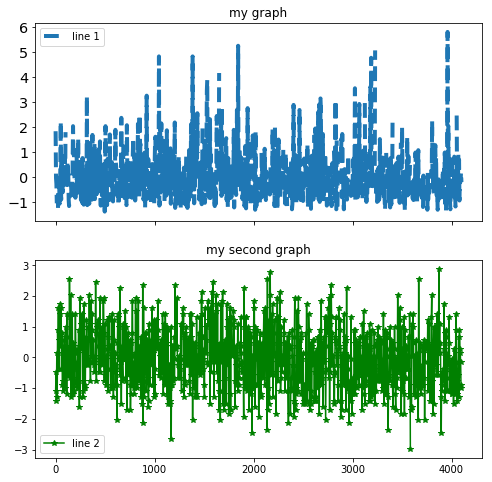

In [901]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(8,8))

one = long_dataset_w1["tmtb"].plot(subplots=True, ax=axes[0], linewidth=4, linestyle="--",
                                  fontsize="x-large")
axes[0].set_title("my graph")
# one.set_title("Graph1")
axes[0].legend(["line 1"])

two = long_dataset_w1["rvltt"].plot(ax = axes[1], color="green", marker="*", sharex=True, title="blah2")
axes[1].set_title("my second graph") # this overrides "title" in the syntax above

axes[1].legend(["line 2"])
# two.set_title("Graph2")



array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002110D46D8D0>,
      dtype=object)

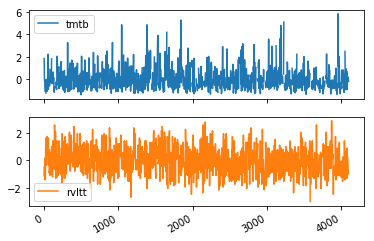

In [872]:
long_dataset_w1[["tmtb","rvltt"]].plot(subplots=True)